# Visualization of Ensemble 

From simple visualization of the states of ensemble members to Accurancy and physical consistancy score of ensemble.
 1. Ocean state visualization
 2. Vertical plot of perturbation
 3. Propagation of perturbation (animation)
 4. Ensemble statistics
 5. Multi variate correlation
 6. High variance zone score 

In [ ]:
import xarray as xr
import glob
import os
from pathlib import Path

## Load Ensemble

From a ensemble directory, get a all ensemble.
In order to load ensemble correctly, make sure your files corresponds to following:

**The members should be in GLONET input format : [input1.nc, input2.nc, input3.nc]** </br>
**Name of the ensemble should be ended by '_input\*.nc'**

In [ ]:

# Set the path to your ensemble data
ens_path = "/Odyssey/private/j25lee/glonet/output/prop_1"  # Adjust this path as needed

In [ ]:
# Method 1: Automated approach for handling many ensemble members
def load_ensemble_datasets(ens_path, max_ensembles=100):
    """
    Load ensemble datasets automatically by scanning the directory.
    
    Parameters:
    ens_path: path to the directory containing ensemble files
    max_ensembles: maximum number of ensemble members to load
    
    Returns:
    Dictionary of ensemble datasets
    """
    ensemble_datasets = {}
    
    # Get all unique ensemble prefixes in the directory
    all_files = glob.glob(os.path.join(ens_path, "*.nc"))
    ensemble_prefixes = set()
    
    for file in all_files:
        filename = os.path.basename(file)
        # Extract ensemble prefix (e.g., "en1_2d", "en2_2d", etc.)
        if "_2d__input" in filename:
            prefix = filename.split("__input")[0]
            ensemble_prefixes.add(prefix)
    
    # Sort ensemble prefixes for consistent ordering
    ensemble_prefixes = sorted(list(ensemble_prefixes))
    
    print(f"Found {len(ensemble_prefixes)} ensemble prefixes: {ensemble_prefixes[:10]}...")  # Show first 10
    
    # Load each ensemble (up to max_ensembles)
    for i, prefix in enumerate(ensemble_prefixes[:max_ensembles]):
        # Find all input files for this ensemble
        pattern = os.path.join(ens_path, f"{prefix}__input*.nc")
        input_files = sorted(glob.glob(pattern))
        
        if input_files:
            print(f"Loading ensemble {i+1}: {prefix} with {len(input_files)} files")
            try:
                ens_ds = xr.open_mfdataset(
                    input_files,
                    concat_dim="ch",
                    combine="nested",
                    chunks={"time": 15, "lat": 96, "lon": 96}
                )
                ens_ds = ens_ds.assign_coords(ch=range(0, len(ens_ds.ch)))
                ensemble_datasets[f'ens{i+1}'] = ens_ds
            except Exception as e:
                print(f"Error loading {prefix}: {e}")
    
    return ensemble_datasets

In [ ]:
# Load all ensemble datasets
ensemble = load_ensemble_datasets(ens_path, max_ensembles=5)

In [ ]:
len(ensemble)

## Ocean states visualizaion ##

Let's investigate ocean state in specific temporal, spatial point and value by ensemble member.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize

In [ ]:
# Define investigating target
time_idx = 1
ch = 0

In [ ]:
def visualize_ensemble_member(ensemble, member='ens1', time_idx=0, ch=0, variable=None, 
                             figsize=(12, 8), cmap='RdYlBu_r', title=None):
    """
    Visualize a specific ensemble member using pcolormesh.
    
    Parameters:
    ensemble: Dictionary of ensemble datasets
    member: Ensemble member key (e.g., 'ens1', 'ens2')
    time_idx: Time index to visualize
    ch: Channel index to visualize
    variable: Variable name to plot (if None, uses first data variable)
    figsize: Figure size tuple
    cmap: Colormap for the plot
    title: Custom title for the plot
    
    Returns:
    fig, ax: matplotlib figure and axes objects
    """
    
    # Check if member exists
    if member not in ensemble:
        print(f"Available ensemble members: {list(ensemble.keys())}")
        raise ValueError(f"Member '{member}' not found in ensemble")
    
    # Get the dataset for the specified member
    ds = ensemble[member]
    
    # Get available variables
    data_vars = list(ds.data_vars)
    if variable is None:
        variable = data_vars[0]  # Use first variable if not specified
        print(f"Using variable: {variable}")
    
    # Check dimensions
    print(f"Dataset dimensions: {dict(ds.dims)}")
    print(f"Available variables: {data_vars}")
    
    # Get the data for plotting
    try:
        data = ds[variable].isel(time=time_idx, ch=ch)
    except (KeyError, IndexError) as e:
        print(f"Error selecting data: {e}")
        print(f"Available dimensions for {variable}: {ds[variable].dims}")
        print(f"Shape: {ds[variable].shape}")
        return None, None
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Use pcolormesh for visualization
    if 'lat' in data.dims and 'lon' in data.dims:
        # If lat/lon coordinates are available
        im = ax.pcolormesh(data.lon, data.lat, data, cmap=cmap, shading='auto')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
    else:
        # If using index coordinates
        im = ax.pcolormesh(data, cmap=cmap, shading='auto')
        ax.set_xlabel('X index')
        ax.set_ylabel('Y index')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(f'{variable}')
    
    # Set title
    if title is None:
        title = f'{member} - {variable}\nTime: {time_idx}, Channel: {ch}'
    ax.set_title(title)
    
    # Set aspect ratio
    ax.set_aspect('equal')
    
    plt.tight_layout()
    return fig, ax

# Example usage function
def plot_ensemble_comparison(ensemble, time_idx=0, ch=0, variable=None, members=['ens1', 'ens2'], 
                           figsize=(15, 6), cmap='RdYlBu_r'):
    """
    Compare multiple ensemble members side by side.
    """
    n_members = len(members)
    fig, axes = plt.subplots(1, n_members, figsize=figsize)
    
    if n_members == 1:
        axes = [axes]
    
    for i, member in enumerate(members):
        if member not in ensemble:
            print(f"Skipping {member} - not found in ensemble")
            continue
            
        ds = ensemble[member]
        data_vars = list(ds.data_vars)
        if variable is None:
            variable = data_vars[0]
        
        try:
            data = ds[variable].isel(time=time_idx, ch=ch)
            
            if 'lat' in data.dims and 'lon' in data.dims:
                im = axes[i].pcolormesh(data.lon, data.lat, data, cmap=cmap, shading='auto')
                axes[i].set_xlabel('Longitude')
                axes[i].set_ylabel('Latitude')
            else:
                im = axes[i].pcolormesh(data, cmap=cmap, shading='auto')
                axes[i].set_xlabel('X index')
                axes[i].set_ylabel('Y index')
            
            axes[i].set_title(f'{member}\nTime: {time_idx}, Ch: {ch}')
            axes[i].set_aspect('equal')
            
            # Add colorbar
            plt.colorbar(im, ax=axes[i])
            
        except Exception as e:
            print(f"Error plotting {member}: {e}")
    
    plt.tight_layout()
    return fig, axes

In [ ]:
# Example 1: Visualize a single ensemble member
# You can adjust these parameters:
member = 'ens1'        # Choose ensemble member: 'ens1', 'ens2', etc.

fig, ax = visualize_ensemble_member(ensemble, member=member, time_idx=time_idx, ch=ch)
plt.show()

In [ ]:
# Example 2: Compare multiple ensemble members
# Compare first two ensemble members at the same time and channel
fig, axes = plot_ensemble_comparison(ensemble, 
                                   time_idx=time_idx, 
                                   ch=ch, 
                                   members=['ens1', 'ens2'])
plt.show()

In [ ]:
# Define regions of interest (dynamical zones)
regions = {
    'Gulf Stream': {'lat_min': 30, 'lat_max': 45, 'lon_min': -80, 'lon_max': -60},
    'Agulhas Current': {'lat_min': -45, 'lat_max': -30, 'lon_min': 15, 'lon_max': 35},
    'Kuroshio Current': {'lat_min': 30, 'lat_max': 45, 'lon_min': 130, 'lon_max': 150},
    'Antarctic Circumpolar': {'lat_min': -65, 'lat_max': -45, 'lon_min': -180, 'lon_max': 180}
}

In [ ]:
def plot_regional_ensemble_comparison(ensemble, regions, time_idx=0, ch=0, variable=None, 
                                     members=['ens1', 'ens2'], figsize=(20, 12), cmap='RdYlBu_r'):
    """
    Compare ensemble members across different regions of interest.
    
    Parameters:
    ensemble: Dictionary of ensemble datasets
    regions: Dictionary of regions with lat/lon bounds
    time_idx: Time index to visualize
    ch: Channel index to visualize
    variable: Variable name to plot (if None, uses first data variable)
    members: List of ensemble members to compare
    figsize: Figure size tuple
    cmap: Colormap for the plot
    
    Returns:
    fig, axes: matplotlib figure and axes objects
    """
    n_regions = len(regions)
    n_members = len(members)
    
    # Create subplots: rows = regions, columns = ensemble members
    fig, axes = plt.subplots(n_regions, n_members, figsize=figsize)
    
    # Ensure axes is always 2D array
    if n_regions == 1:
        axes = axes.reshape(1, -1)
    if n_members == 1:
        axes = axes.reshape(-1, 1)
    
    # Get variable name if not specified
    if variable is None and ensemble:
        first_member = list(ensemble.keys())[0]
        variable = list(ensemble[first_member].data_vars)[0]
        print(f"Using variable: {variable}")
    
    # Plot each region and ensemble member combination
    for row, (region_name, bounds) in enumerate(regions.items()):
        for col, member in enumerate(members):
            ax = axes[row, col]
            
            if member not in ensemble:
                ax.text(0.5, 0.5, f'{member}\nnot found', ha='center', va='center', 
                       transform=ax.transAxes, fontsize=12)
                ax.set_title(f'{region_name} - {member}')
                continue
            
            try:
                # Get the dataset
                ds = ensemble[member]
                data = ds[variable].isel(time=time_idx, ch=ch)
                
                # Extract regional data
                if 'lat' in data.dims and 'lon' in data.dims:
                    # Select region based on lat/lon bounds
                    regional_data = data.sel(
                        lat=slice(bounds['lat_min'], bounds['lat_max']),
                        lon=slice(bounds['lon_min'], bounds['lon_max'])
                    )
                    
                    # Plot the regional data
                    im = ax.pcolormesh(regional_data.lon, regional_data.lat, regional_data, 
                                     cmap=cmap, shading='auto')
                    ax.set_xlabel('Longitude')
                    ax.set_ylabel('Latitude')
                    
                else:
                    # If no lat/lon coords, use the full data (fallback)
                    im = ax.pcolormesh(data, cmap=cmap, shading='auto')
                    ax.set_xlabel('X index')
                    ax.set_ylabel('Y index')
                
                # Set title and formatting
                ax.set_title(f'{region_name}\n{member} (T:{time_idx}, Ch:{ch})')
                ax.set_aspect('equal')
                
                # Add colorbar
                plt.colorbar(im, ax=ax, shrink=0.6)
                
            except Exception as e:
                print(f"Error plotting {member} for {region_name}: {e}")
                ax.text(0.5, 0.5, f'Error:\n{str(e)[:50]}...', ha='center', va='center', 
                       transform=ax.transAxes, fontsize=10)
                ax.set_title(f'{region_name} - {member} (Error)')
    
    plt.tight_layout()
    return fig, axes

def plot_single_region_ensemble(ensemble, region_name, region_bounds, time_idx=0, ch=0, 
                               variable=None, members=None, figsize=(15, 10), cmap='RdYlBu_r'):
    """
    Plot all ensemble members for a single region.
    
    Parameters:
    ensemble: Dictionary of ensemble datasets
    region_name: Name of the region
    region_bounds: Dictionary with lat_min, lat_max, lon_min, lon_max
    time_idx: Time index to visualize
    ch: Channel index to visualize
    variable: Variable name to plot
    members: List of members to plot (if None, uses all available)
    figsize: Figure size tuple
    cmap: Colormap for the plot
    
    Returns:
    fig, axes: matplotlib figure and axes objects
    """
    if members is None:
        members = list(ensemble.keys())
    
    n_members = len(members)
    
    # Calculate subplot layout
    cols = min(3, n_members)  # Max 3 columns
    rows = (n_members + cols - 1) // cols  # Ceiling division
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Ensure axes is always a list
    if n_members == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes if isinstance(axes, (list, np.ndarray)) else [axes]
    else:
        axes = axes.flatten()
    
    # Get variable name if not specified
    if variable is None and ensemble:
        first_member = list(ensemble.keys())[0]
        variable = list(ensemble[first_member].data_vars)[0]
        print(f"Using variable: {variable}")
    
    for i, member in enumerate(members):
        ax = axes[i]
        
        if member not in ensemble:
            ax.text(0.5, 0.5, f'{member}\nnot found', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=12)
            ax.set_title(f'{member}')
            continue
        
        try:
            # Get the dataset
            ds = ensemble[member]
            data = ds[variable].isel(time=time_idx, ch=ch)
            
            # Extract regional data
            if 'lat' in data.dims and 'lon' in data.dims:
                regional_data = data.sel(
                    lat=slice(region_bounds['lat_min'], region_bounds['lat_max']),
                    lon=slice(region_bounds['lon_min'], region_bounds['lon_max'])
                )
                
                im = ax.pcolormesh(regional_data.lon, regional_data.lat, regional_data, 
                                 cmap=cmap, shading='auto')
                ax.set_xlabel('Longitude')
                ax.set_ylabel('Latitude')
            else:
                im = ax.pcolormesh(data, cmap=cmap, shading='auto')
                ax.set_xlabel('X index')
                ax.set_ylabel('Y index')
            
            ax.set_title(f'{member}\nT:{time_idx}, Ch:{ch}')
            ax.set_aspect('equal')
            
            # Add colorbar
            plt.colorbar(im, ax=ax, shrink=0.8)
            
        except Exception as e:
            print(f"Error plotting {member}: {e}")
            ax.text(0.5, 0.5, f'Error:\n{str(e)[:30]}...', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=10)
            ax.set_title(f'{member} (Error)')
    
    # Hide unused subplots
    for i in range(n_members, len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle(f'{region_name} - Ensemble Comparison', fontsize=16, y=0.95)
    plt.tight_layout()
    return fig, axes

In [ ]:
# Example 1: Compare ensemble members across all regions
# This creates a grid: rows = regions, columns = ensemble members
fig, axes = plot_regional_ensemble_comparison(
    ensemble, 
    regions, 
    time_idx=time_idx, 
    ch=ch, 
    members=['ens1', 'ens2', 'ens3']  # Add more members as needed
)
plt.show()

In [ ]:
# Example 2: Focus on a single region - Gulf Stream
# Show all ensemble members for one specific region
fig, axes = plot_single_region_ensemble(
    ensemble, 
    region_name='Gulf Stream',
    region_bounds=regions['Gulf Stream'],
    time_idx=time_idx, 
    ch=ch,
    members=['ens1', 'ens2', 'ens3', 'ens4', 'ens5']  # Include all available members
)
plt.show()

### Ensemble Animation for Large Datasets ###

For testing with 100+ ensemble members, animations are much more efficient than individual plots. 
Two types of animations are available:
1. **Ensemble Member Animation**: Cycle through all members at fixed time - perfect for comparing ensemble spread
2. **Temporal Animation**: Show time evolution for a single member - great for understanding dynamics

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib.patches as patches

def create_ensemble_member_animation(ensemble, time_idx=0, ch=0, variable=None, 
                                   region_name=None, region_bounds=None,
                                   figsize=(10, 8), cmap='RdYlBu_r', 
                                   interval=800, save_gif=False, gif_filename='ensemble_animation.gif'):
    """
    Create animation cycling through ensemble members at a fixed time.
    Perfect for comparing 100+ ensemble members efficiently.
    
    Parameters:
    ensemble: Dictionary of ensemble datasets
    time_idx: Fixed time index to visualize
    ch: Channel index to visualize
    variable: Variable name to plot
    region_name: Name of region for title (optional)
    region_bounds: Dictionary with lat/lon bounds for regional focus
    figsize: Figure size tuple
    cmap: Colormap for the plot
    interval: Animation interval in milliseconds
    save_gif: Whether to save animation as GIF
    gif_filename: Filename for saved GIF
    
    Returns:
    fig, ani: matplotlib figure and animation objects
    """
    
    # Get ensemble members list
    members = list(ensemble.keys())
    if not members:
        print("No ensemble members found!")
        return None, None
    
    print(f"Creating animation for {len(members)} ensemble members")
    
    # Get variable name if not specified
    if variable is None:
        first_member = members[0]
        variable = list(ensemble[first_member].data_vars)[0]
        print(f"Using variable: {variable}")
    
    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get data range for consistent colorbar
    vmin, vmax = None, None
    sample_data_list = []
    
    for member in members[:min(5, len(members))]:  # Sample first 5 for range
        try:
            ds = ensemble[member]
            data = ds[variable].isel(time=time_idx, ch=ch)
            
            if region_bounds and 'lat' in data.dims and 'lon' in data.dims:
                data = data.sel(
                    lat=slice(region_bounds['lat_min'], region_bounds['lat_max']),
                    lon=slice(region_bounds['lon_min'], region_bounds['lon_max'])
                )
            
            sample_data_list.append(data)
        except Exception as e:
            print(f"Error sampling {member}: {e}")
    
    if sample_data_list:
        all_data = sample_data_list[0]
        for data in sample_data_list[1:]:
            all_data = all_data.combine_first(data)
        vmin, vmax = float(all_data.min()), float(all_data.max())
    
    # Initialize plot elements
    im = None
    title_text = ax.text(0.5, 1.02, '', transform=ax.transAxes, ha='center', fontsize=14, weight='bold')
    member_counter = ax.text(0.02, 0.98, '', transform=ax.transAxes, ha='left', va='top', 
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    def animate(frame):
        nonlocal im
        
        member = members[frame]
        
        try:
            # Get data for current member
            ds = ensemble[member]
            data = ds[variable].isel(time=time_idx, ch=ch)
            
            # Apply regional selection if specified
            if region_bounds and 'lat' in data.dims and 'lon' in data.dims:
                data = data.sel(
                    lat=slice(region_bounds['lat_min'], region_bounds['lat_max']),
                    lon=slice(region_bounds['lon_min'], region_bounds['lon_max'])
                )
            
            # Clear previous plot
            ax.clear()
            
            # Create new plot
            if 'lat' in data.dims and 'lon' in data.dims:
                im = ax.pcolormesh(data.lon, data.lat, data, cmap=cmap, 
                                 shading='auto', vmin=vmin, vmax=vmax)
                ax.set_xlabel('Longitude')
                ax.set_ylabel('Latitude')
            else:
                im = ax.pcolormesh(data, cmap=cmap, shading='auto', vmin=vmin, vmax=vmax)
                ax.set_xlabel('X index')
                ax.set_ylabel('Y index')
            
            # Set formatting
            ax.set_aspect('equal')
            
            # Update title and counter
            region_str = f" - {region_name}" if region_name else ""
            title = f'Ensemble Member: {member}{region_str}\nTime: {time_idx}, Channel: {ch}'
            ax.set_title(title)
            
            # Add member counter
            ax.text(0.02, 0.98, f'Member {frame+1}/{len(members)}', 
                   transform=ax.transAxes, ha='left', va='top',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
            
            # Add colorbar (only once)
            if frame == 0:
                plt.colorbar(im, ax=ax, shrink=0.8, label=variable)
                
        except Exception as e:
            ax.text(0.5, 0.5, f'Error loading {member}:\n{str(e)[:50]}...', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'Error - {member}')
    
    # Create animation
    ani = animation.FuncAnimation(fig, animate, frames=len(members), 
                                interval=interval, repeat=True, blit=False)
    
    # Save as GIF if requested
    if save_gif:
        print(f"Saving animation as {gif_filename}...")
        ani.save(gif_filename, writer='pillow', fps=1000/interval)
        print("Animation saved!")
    
    plt.tight_layout()
    return fig, ani

def create_temporal_ensemble_animation(ensemble, member='ens1', ch=0, variable=None,
                                     region_name=None, region_bounds=None,  
                                     figsize=(10, 8), cmap='RdYlBu_r',
                                     interval=500, save_gif=False, gif_filename='temporal_animation.gif'):
    """
    Create animation showing temporal evolution for a single ensemble member.
    Great for understanding how patterns evolve over time in a specific region.
    
    Parameters:
    ensemble: Dictionary of ensemble datasets
    member: Ensemble member to animate
    ch: Channel index to visualize
    variable: Variable name to plot
    region_name: Name of region for title
    region_bounds: Dictionary with lat/lon bounds for regional focus
    figsize: Figure size tuple
    cmap: Colormap for the plot
    interval: Animation interval in milliseconds
    save_gif: Whether to save animation as GIF
    gif_filename: Filename for saved GIF
    
    Returns:
    fig, ani: matplotlib figure and animation objects
    """
    
    if member not in ensemble:
        print(f"Member {member} not found in ensemble!")
        return None, None
    
    # Get dataset
    ds = ensemble[member]
    
    # Get variable name if not specified
    if variable is None:
        variable = list(ds.data_vars)[0]
        print(f"Using variable: {variable}")
    
    # Get time dimension
    n_times = ds.dims['time']
    print(f"Creating temporal animation for {n_times} time steps")
    
    # Set up the figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get data range for consistent colorbar
    try:
        sample_data = ds[variable].isel(ch=ch)
        if region_bounds and 'lat' in sample_data.dims and 'lon' in sample_data.dims:
            sample_data = sample_data.sel(
                lat=slice(region_bounds['lat_min'], region_bounds['lat_max']),
                lon=slice(region_bounds['lon_min'], region_bounds['lon_max'])
            )
        vmin, vmax = float(sample_data.min()), float(sample_data.max())
    except Exception as e:
        print(f"Error getting data range: {e}")
        vmin, vmax = None, None
    
    def animate(frame):
        try:
            # Get data for current time step
            data = ds[variable].isel(time=frame, ch=ch)
            
            # Apply regional selection if specified
            if region_bounds and 'lat' in data.dims and 'lon' in data.dims:
                data = data.sel(
                    lat=slice(region_bounds['lat_min'], region_bounds['lat_max']),
                    lon=slice(region_bounds['lon_min'], region_bounds['lon_max'])
                )
            
            # Clear previous plot
            ax.clear()
            
            # Create new plot
            if 'lat' in data.dims and 'lon' in data.dims:
                im = ax.pcolormesh(data.lon, data.lat, data, cmap=cmap, 
                                 shading='auto', vmin=vmin, vmax=vmax)
                ax.set_xlabel('Longitude')
                ax.set_ylabel('Latitude')
            else:
                im = ax.pcolormesh(data, cmap=cmap, shading='auto', vmin=vmin, vmax=vmax)
                ax.set_xlabel('X index')
                ax.set_ylabel('Y index')
            
            # Set formatting
            ax.set_aspect('equal')
            
            # Update title
            region_str = f" - {region_name}" if region_name else ""
            title = f'{member}{region_str} - Temporal Evolution\nTime Step: {frame}/{n_times-1}, Channel: {ch}'
            ax.set_title(title)
            
            # Add time counter
            ax.text(0.02, 0.98, f'Time {frame+1}/{n_times}', 
                   transform=ax.transAxes, ha='left', va='top',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
            
            # Add colorbar (only once)
            if frame == 0:
                plt.colorbar(im, ax=ax, shrink=0.8, label=variable)
                
        except Exception as e:
            ax.text(0.5, 0.5, f'Error at time {frame}:\n{str(e)[:50]}...', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'Error - Time {frame}')
    
    # Create animation
    ani = animation.FuncAnimation(fig, animate, frames=n_times, 
                                interval=interval, repeat=True, blit=False)
    
    # Save as GIF if requested
    if save_gif:
        print(f"Saving temporal animation as {gif_filename}...")
        ani.save(gif_filename, writer='pillow', fps=1000/interval)
        print("Temporal animation saved!")
    
    plt.tight_layout()
    return fig, ani

Plot the animations

In [ ]:
# Animation 1: Cycle through ALL ensemble members (perfect for 100+ members)
# Focus on Gulf Stream region at a specific time
fig, ani = create_ensemble_member_animation(
    ensemble, 
    time_idx=time_idx,  # Fixed time point
    ch=ch,
    region_name='Gulf Stream',
    region_bounds=regions['Gulf Stream'],
    interval=600,  # 600ms between frames - adjust for speed
    save_gif=False  # Set to True to save as GIF
)

# Display the animation
HTML(ani.to_jshtml())

In [ ]:
# Animation 2: Temporal evolution for a single ensemble member
# Great for understanding how patterns evolve over time in Gulf Stream
fig, ani = create_temporal_ensemble_animation(
    ensemble,
    member='ens1',  # Choose which member to analyze
    ch=ch,
    region_name='Gulf Stream',
    region_bounds=regions['Gulf Stream'],
    interval=400,  # Faster animation for temporal evolution
    save_gif=False
)

# Display the animation
HTML(ani.to_jshtml())

In [ ]:
# Animation 3: Global view - cycle through ensemble members without regional focus
# Useful for seeing full domain differences
fig, ani = create_ensemble_member_animation(
    ensemble, 
    time_idx=time_idx,
    ch=ch,
    region_name=None,  # No regional focus - show full domain
    region_bounds=None,
    interval=700,
    figsize=(12, 10),  # Larger figure for global view
    save_gif=False
)

# Display the animation
HTML(ani.to_jshtml())

In [ ]:
# Animation 4: Compare different regions - loop through regions with ensemble cycling
def create_multi_region_animation(ensemble, regions, time_idx=0, ch=0, members_per_region=5):
    """
    Create animations for multiple regions, cycling through ensemble members in each region.
    Perfect for systematic comparison across different oceanic regions.
    """
    animations = {}
    
    for region_name, region_bounds in regions.items():
        print(f"Creating animation for {region_name}...")
        
        # Get subset of members for this region (to avoid too long animations)
        available_members = list(ensemble.keys())
        selected_members = available_members[:members_per_region]
        
        # Create temporary ensemble subset
        temp_ensemble = {k: v for k, v in ensemble.items() if k in selected_members}
        
        fig, ani = create_ensemble_member_animation(
            temp_ensemble,
            time_idx=time_idx,
            ch=ch,
            region_name=region_name,
            region_bounds=region_bounds,
            interval=800,
            figsize=(10, 8)
        )
        
        animations[region_name] = (fig, ani)
        
        # Display immediately
        print(f"Animation for {region_name}:")
        display(HTML(ani.to_jshtml()))
        
    return animations


In [ ]:

# Create animations for all regions (first 5 members each)
animations = create_multi_region_animation(ensemble, regions, time_idx=time_idx, ch=ch, members_per_region=3)

# Uncomment the line above to run multi-region animations
print("Multi-region animation function ready. Uncomment the line above to run.")

## Vertical Perturbation Analysis

Now let's analyze the vertical structure of perturbations to investigate physics consistency. We'll examine:

1. **Point profiles**: Vertical profiles at specific locations
2. **Cross-sections**: 2D vertical slices through the ocean
3. **Statistics by depth**: How perturbations vary with depth across the domain

The data structure:
- **Channels 0-4**: Surface data
- **Channels 5-84**: Depth ocean states (80 channels for 4 variables × 20 depth levels)
  - Variables: thetao (temperature), so (salinity), uo (zonal velocity), vo (meridional velocity)

In [131]:
# To calculate perturbation, load the reference (ground truth value GLORYS12) 

ref_path = "/Odyssey/public/glonet/2022-07-02_init_states"
input_ref = [ref_path + "/input1.nc", ref_path + "/input2.nc", ref_path + "/input3.nc"]

ref = xr.open_mfdataset(input_ref,
                    concat_dim="ch",
                    combine="nested",
                    chunks={"time": 15, "lat": 96, "lon": 96}
                )

In [132]:
ref = ref.assign_coords(ch=range(0, len(ref.ch)))

In [125]:
def calculate_perturbations(ensemble, ref, member='ens1', time_idx=None):
    """
    Calculate perturbations (member - reference) for vertical analysis.
    
    Parameters:
    ensemble: Dictionary of ensemble datasets
    ref: Reference dataset (GLORYS12)
    member: Ensemble member to analyze
    time_idx: Time index to use (if None, returns perturbations for all times)
    
    Returns:
    perturbation: xarray Dataset with perturbations
    """
    if member not in ensemble:
        raise ValueError(f"Member {member} not found in ensemble")
    
    # Get the ensemble member data
    ens_data = ensemble[member]
    
    # Handle time coordinate mismatch by selecting specific time indices
    if time_idx is not None:
        # Select specific time index from both datasets
        ens_t = ens_data.isel(time=time_idx)
        ref_t = ref.isel(time=time_idx)
        perturbation = ens_t - ref_t
    else:
        # For multiple times, calculate perturbations for each time separately
        perturbations = []
        n_times = min(ens_data.sizes['time'], ref.sizes['time'])
        
        for t in range(n_times):
            ens_t = ens_data.isel(time=t)
            ref_t = ref.isel(time=t)
            pert_t = ens_t - ref_t
            perturbations.append(pert_t.expand_dims('time'))
        
        if perturbations:
            perturbation = xr.concat(perturbations, dim='time')
        else:
            raise ValueError("No valid time indices found for perturbation calculation")
    
    return perturbation

def get_depth_info():
    """
    Define the depth structure for GLONET data.
    
    CORRECT STRUCTURE:
    - Channels 0-4: Surface data
    - Channels 5-84: Depth data organized as:
      * Channels 5-14: thetao (10 depth levels - shallow)
      * Channels 15-24: so (10 depth levels - shallow) 
      * Channels 25-34: uo (10 depth levels - shallow)
      * Channels 35-44: vo (10 depth levels - shallow)
      * Channels 45-54: thetao (10 depth levels - deep)
      * Channels 55-64: so (10 depth levels - deep)
      * Channels 65-74: uo (10 depth levels - deep)
      * Channels 75-84: vo (10 depth levels - deep)
    
    Returns:
    depth_info: Dictionary with depth level information
    """
    # Surface channels (0-4)
    surface_channels = list(range(0, 5))
    
    # Depth channels (5-84): 2 depth groups × 4 variables × 10 levels = 80 channels
    depth_channels = list(range(5, 85))
    
    # Channel mapping for each variable
    channel_mapping = {
        'thetao': list(range(5, 15)) + list(range(45, 55)),    # shallow + deep thetao
        'so':     list(range(15, 25)) + list(range(55, 65)),   # shallow + deep salinity  
        'uo':     list(range(25, 35)) + list(range(65, 75)),   # shallow + deep u-velocity
        'vo':     list(range(35, 45)) + list(range(75, 85))    # shallow + deep v-velocity
    }
    
    depth_info = {
        'surface_channels': surface_channels,
        'depth_channels': depth_channels,
        'n_depth_levels': 20,  # 10 shallow + 10 deep levels per variable
        'levels_per_group': 10,  # 10 levels in each depth group
        'n_depth_groups': 2,     # shallow and deep
        'variable_names': ['thetao', 'so', 'uo', 'vo'],
        'channel_mapping': channel_mapping
    }
    
    return depth_info

def extract_depth_profile(data, lat_idx, lon_idx, variable_idx=0):
    """
    Extract vertical profile at a specific location using CORRECT channel structure.
    
    Parameters:
    data: xarray Dataset
    lat_idx: Latitude index
    lon_idx: Longitude index  
    variable_idx: Variable index (0=thetao, 1=so, 2=uo, 3=vo)
    
    Returns:
    profile: 1D array of values at all depth levels (20 levels: 10 shallow + 10 deep)
    """
    depth_info = get_depth_info()
    
    # Get the correct channels for the specific variable
    variable_name = depth_info['variable_names'][variable_idx]
    depth_chs = depth_info['channel_mapping'][variable_name]
    
    # Extract profile
    profile = []
    for ch in depth_chs:
        if ch < data.sizes['ch']:
            # Handle both Dataset and DataArray inputs
            if hasattr(data, 'data_vars') and 'data' in data.data_vars:
                # It's a Dataset with 'data' variable
                value = data['data'].isel(lat=lat_idx, lon=lon_idx, ch=ch)
            else:
                # It's already a DataArray or different structure
                value = data.isel(lat=lat_idx, lon=lon_idx, ch=ch)
            profile.append(float(value.values))
    
    return np.array(profile)

def plot_vertical_perturbation_profile(ensemble, ref, member='ens1', time_idx=0, 
                                     lat_idx=48, lon_idx=48, variable_idx=0,
                                     figsize=(12, 8)):
    """
    Plot vertical profile of perturbations at a specific location.
    
    Parameters:
    ensemble: Dictionary of ensemble datasets
    ref: Reference dataset
    member: Ensemble member to analyze
    time_idx: Time index
    lat_idx: Latitude index (0-95)
    lon_idx: Longitude index (0-95)
    variable_idx: Variable index (0=thetao, 1=so, 2=uo, 3=vo)
    figsize: Figure size
    
    Returns:
    fig, ax: matplotlib figure and axes
    """
    depth_info = get_depth_info()
    var_names = depth_info['variable_names']
    
    # Calculate perturbation using the fixed function
    perturbation = calculate_perturbations(ensemble, ref, member, time_idx=time_idx)
    
    # Get reference and ensemble data at the specified time
    ref_t = ref.isel(time=time_idx)
    ens_t = ensemble[member].isel(time=time_idx)
    
    # Extract vertical profiles
    pert_profile = extract_depth_profile(perturbation, lat_idx, lon_idx, variable_idx)
    ref_profile = extract_depth_profile(ref_t, lat_idx, lon_idx, variable_idx)
    ens_profile = extract_depth_profile(ens_t, lat_idx, lon_idx, variable_idx)
    
    # Create depth levels (assuming standard oceanographic depths)
    # This is a simplified depth scale - you may want to use actual depth coordinates
    n_levels = len(pert_profile)
    depths = np.linspace(0, 5000, n_levels)  # 0 to 5000m depth
    
    # Create plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot 1: Absolute values
    ax1.plot(ref_profile, depths, 'b-', linewidth=2, label='Reference (GLORYS12)')
    ax1.plot(ens_profile, depths, 'r-', linewidth=2, label=f'{member}')
    ax1.invert_yaxis()
    ax1.set_ylabel('Depth (m)')
    ax1.set_xlabel(f'{var_names[variable_idx]} Value')
    ax1.set_title(f'Vertical Profile - {var_names[variable_idx]}\nLocation: ({lat_idx}, {lon_idx})')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Perturbation
    ax2.plot(pert_profile, depths, 'g-', linewidth=2, label='Perturbation (Member - Ref)')
    ax2.axvline(x=0, color='k', linestyle='--', alpha=0.5)
    ax2.invert_yaxis()
    ax2.set_ylabel('Depth (m)')
    ax2.set_xlabel(f'{var_names[variable_idx]} Perturbation')
    ax2.set_title(f'Perturbation Profile\n{member} - Reference')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, (ax1, ax2)

def plot_multi_variable_vertical_profiles(ensemble, ref, member='ens1', time_idx=0,
                                        lat_idx=48, lon_idx=48, figsize=(16, 12)):
    """
    Plot vertical profiles for all 4 variables (thetao, so, uo, vo).
    
    Parameters:
    ensemble: Dictionary of ensemble datasets
    ref: Reference dataset
    member: Ensemble member to analyze
    time_idx: Time index
    lat_idx: Latitude index
    lon_idx: Longitude index
    figsize: Figure size
    
    Returns:
    fig, axes: matplotlib figure and axes array
    """
    depth_info = get_depth_info()
    var_names = depth_info['variable_names']
    
    # Calculate perturbation
    perturbation = calculate_perturbations(ensemble, ref, member)
    
    # Select time
    pert_t = perturbation.isel(time=time_idx)
    ref_t = ref.isel(time=time_idx)
    
    # For ensemble data, align coordinates
    ens_t = ensemble[member].isel(time=time_idx)
    ens_t = ens_t.assign_coords(ch=ref.ch.values)
    
    # Create subplots: 2 rows x 4 columns (absolute values and perturbations for each variable)
    fig, axes = plt.subplots(2, 4, figsize=figsize)
    
    for var_idx, var_name in enumerate(var_names):
        # Extract profiles
        pert_profile = extract_depth_profile(pert_t, lat_idx, lon_idx, var_idx)
        ref_profile = extract_depth_profile(ref_t, lat_idx, lon_idx, var_idx)
        ens_profile = extract_depth_profile(ens_t, lat_idx, lon_idx, var_idx)
        
        # Create depth levels
        n_levels = len(pert_profile)
        depths = np.linspace(0, 5000, n_levels)
        
        # Top row: Absolute values
        ax1 = axes[0, var_idx]
        ax1.plot(ref_profile, depths, 'b-', linewidth=2, label='Reference')
        ax1.plot(ens_profile, depths, 'r-', linewidth=2, label=f'{member}')
        ax1.invert_yaxis()
        ax1.set_ylabel('Depth (m)' if var_idx == 0 else '')
        ax1.set_xlabel(f'{var_name}')
        ax1.set_title(f'{var_name} Profiles')
        if var_idx == 0:
            ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Bottom row: Perturbations
        ax2 = axes[1, var_idx]
        ax2.plot(pert_profile, depths, 'g-', linewidth=2, label='Perturbation')
        ax2.axvline(x=0, color='k', linestyle='--', alpha=0.5)
        ax2.invert_yaxis()
        ax2.set_ylabel('Depth (m)' if var_idx == 0 else '')
        ax2.set_xlabel(f'{var_name} Perturbation')
        ax2.set_title(f'{var_name} Perturbation')
        if var_idx == 0:
            ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    plt.suptitle(f'Vertical Profiles at Location ({lat_idx}, {lon_idx}) - Time {time_idx}', 
                 fontsize=16, y=0.95)
    plt.tight_layout()
    return fig, axes

In [127]:
# First, let's examine the data structure and understand the depth organization
depth_info = get_depth_info()
print("Depth data organization:")
print(f"Surface channels: {depth_info['surface_channels']}")
print(f"Depth channels: {depth_info['depth_channels'][0]} to {depth_info['depth_channels'][-1]}")
print(f"Number of depth levels: {depth_info['n_depth_levels']}")
print(f"Variable names: {depth_info['variable_names']}")
print()

# Check dimensions of our data
print("Ensemble data dimensions:")
for member_name, ds in list(ensemble.items())[:2]:
    print(f"{member_name}: {dict(ds.dims)}")

print(f"\nReference data dimensions: {dict(ref.dims)}")

# Verify the channel dimension matches our understanding
total_expected_channels = len(depth_info['surface_channels']) + len(depth_info['depth_channels'])
actual_channels = ref.sizes['ch']
print(f"Expected total channels: {total_expected_channels}")
print(f"Actual channels in data: {actual_channels}")
print(f"Match: {total_expected_channels == actual_channels}")

Depth data organization:
Surface channels: [0, 1, 2, 3, 4]
Depth channels: 5 to 84
Number of depth levels: 20
Variable names: ['thetao', 'so', 'uo', 'vo']

Ensemble data dimensions:
ens1: {'time': 2, 'ch': 85, 'lat': 672, 'lon': 1440}
ens2: {'time': 2, 'ch': 85, 'lat': 672, 'lon': 1440}

Reference data dimensions: {'time': 2, 'ch': 85, 'lat': 672, 'lon': 1440}
Expected total channels: 85
Actual channels in data: 85
Match: True


/tmp/ipykernel_309170/539142791.py:13: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"{member_name}: {dict(ds.dims)}")
/tmp/ipykernel_309170/539142791.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"\nReference data dimensions: {dict(ref.dims)}")


Analyzing all variables at the same location:


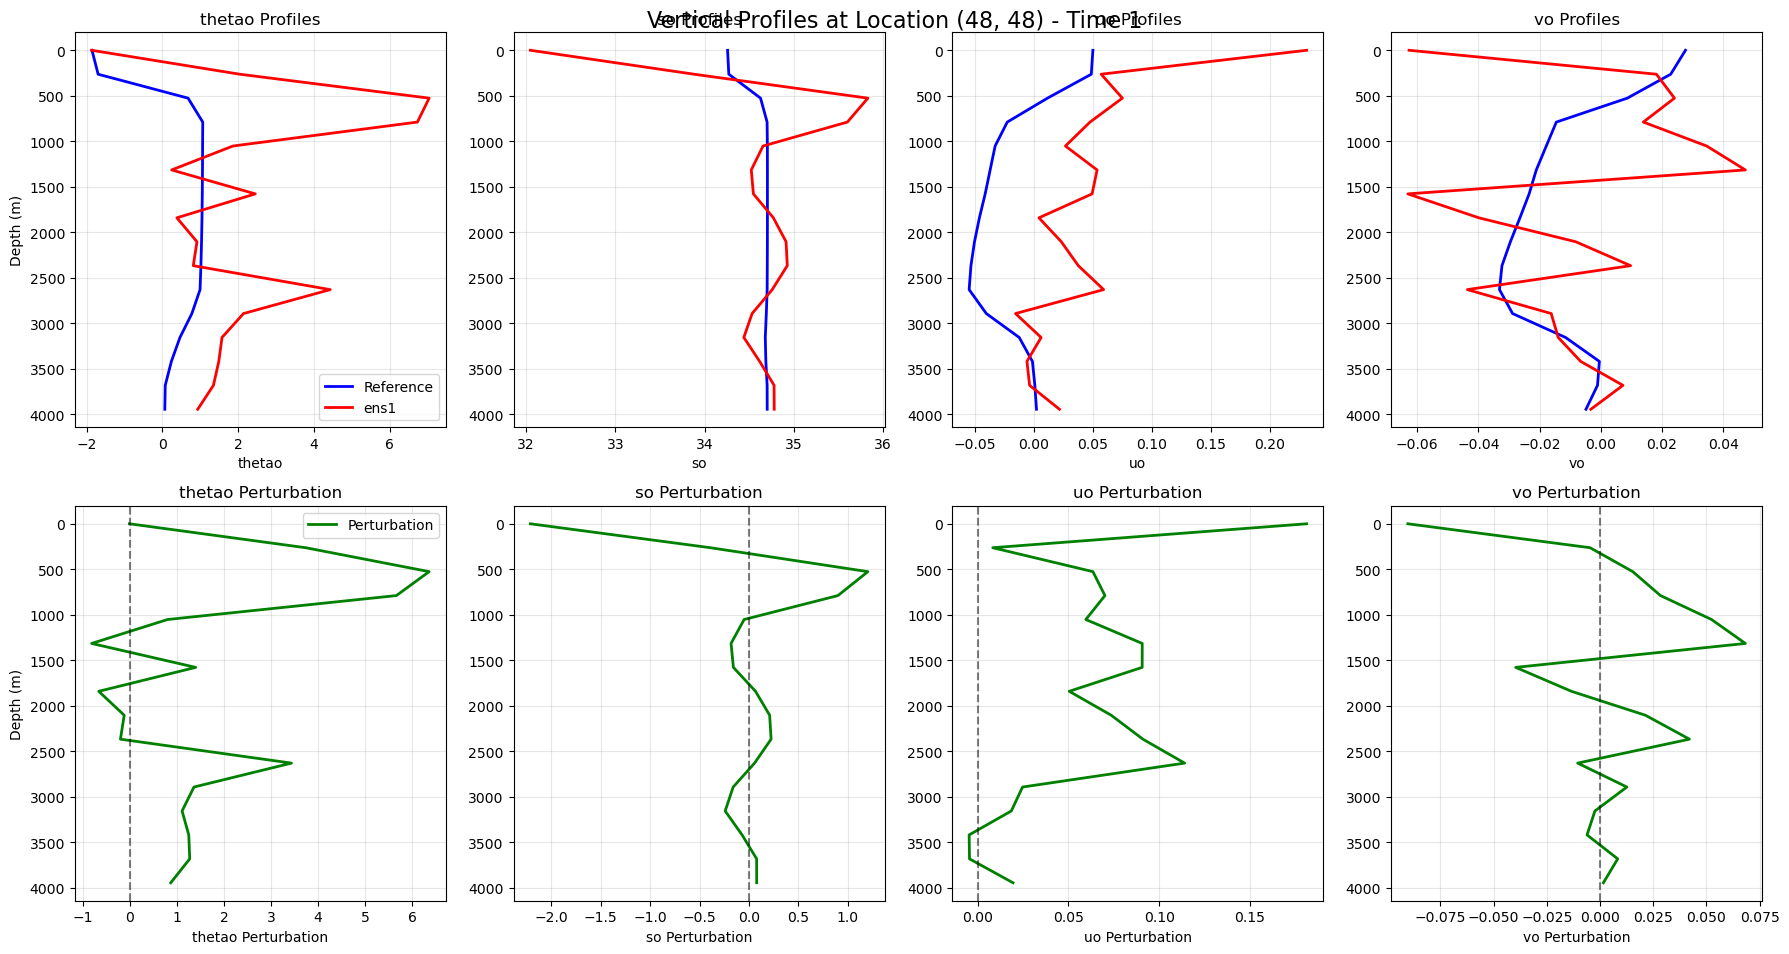

In [133]:
# Example 2: Multi-variable vertical profiles
# Compare all 4 variables (thetao, so, uo, vo) at the same location
print("Analyzing all variables at the same location:")

fig, axes = plot_multi_variable_vertical_profiles(
    ensemble, ref,
    member=member_to_analyze,
    time_idx=time_idx,
    lat_idx=analysis_location[0],
    lon_idx=analysis_location[1],
    figsize=(18, 10)
)
plt.show()

## Ensemble Uncertainties

Get mean and standard deviation (statistics) of ensemble

=== ENSEMBLE STATISTICS ANALYSIS ===
Calculating ensemble statistics...
Processing 5 ensemble members: ['ens1', 'ens2', 'ens3', 'ens4', 'ens5']
Plotting channels: [0, 1, 5, 15, 25, 35]

=== ENSEMBLE STATISTICS SUMMARY ===
Number of ensemble members: 5
Time index analyzed: 1
Grid size: 672 x 1440
Number of channels: 85
Plotting channels: [0, 1, 5, 15, 25, 35]

=== ENSEMBLE STATISTICS SUMMARY ===
Number of ensemble members: 5
Time index analyzed: 1
Grid size: 672 x 1440
Number of channels: 85

Channel  Mean_Avg   Mean_Std   Std_Avg    Std_Max    Uncert_Avg  
----------------------------------------------------------------------
0        -0.1508    0.6690     0.0798     0.6932     1.1592      
1        14.2180    10.7536    1.1675     6.5858     2.6993      
2        33.8527    2.6245     0.8405     15.6420    0.0263      
3        -0.0017    0.1566     0.0882     1.5248     7.7667      
4        0.0082     0.1120     0.0770     1.2131     7.7098      
5        13.6351    9.7731     2.122

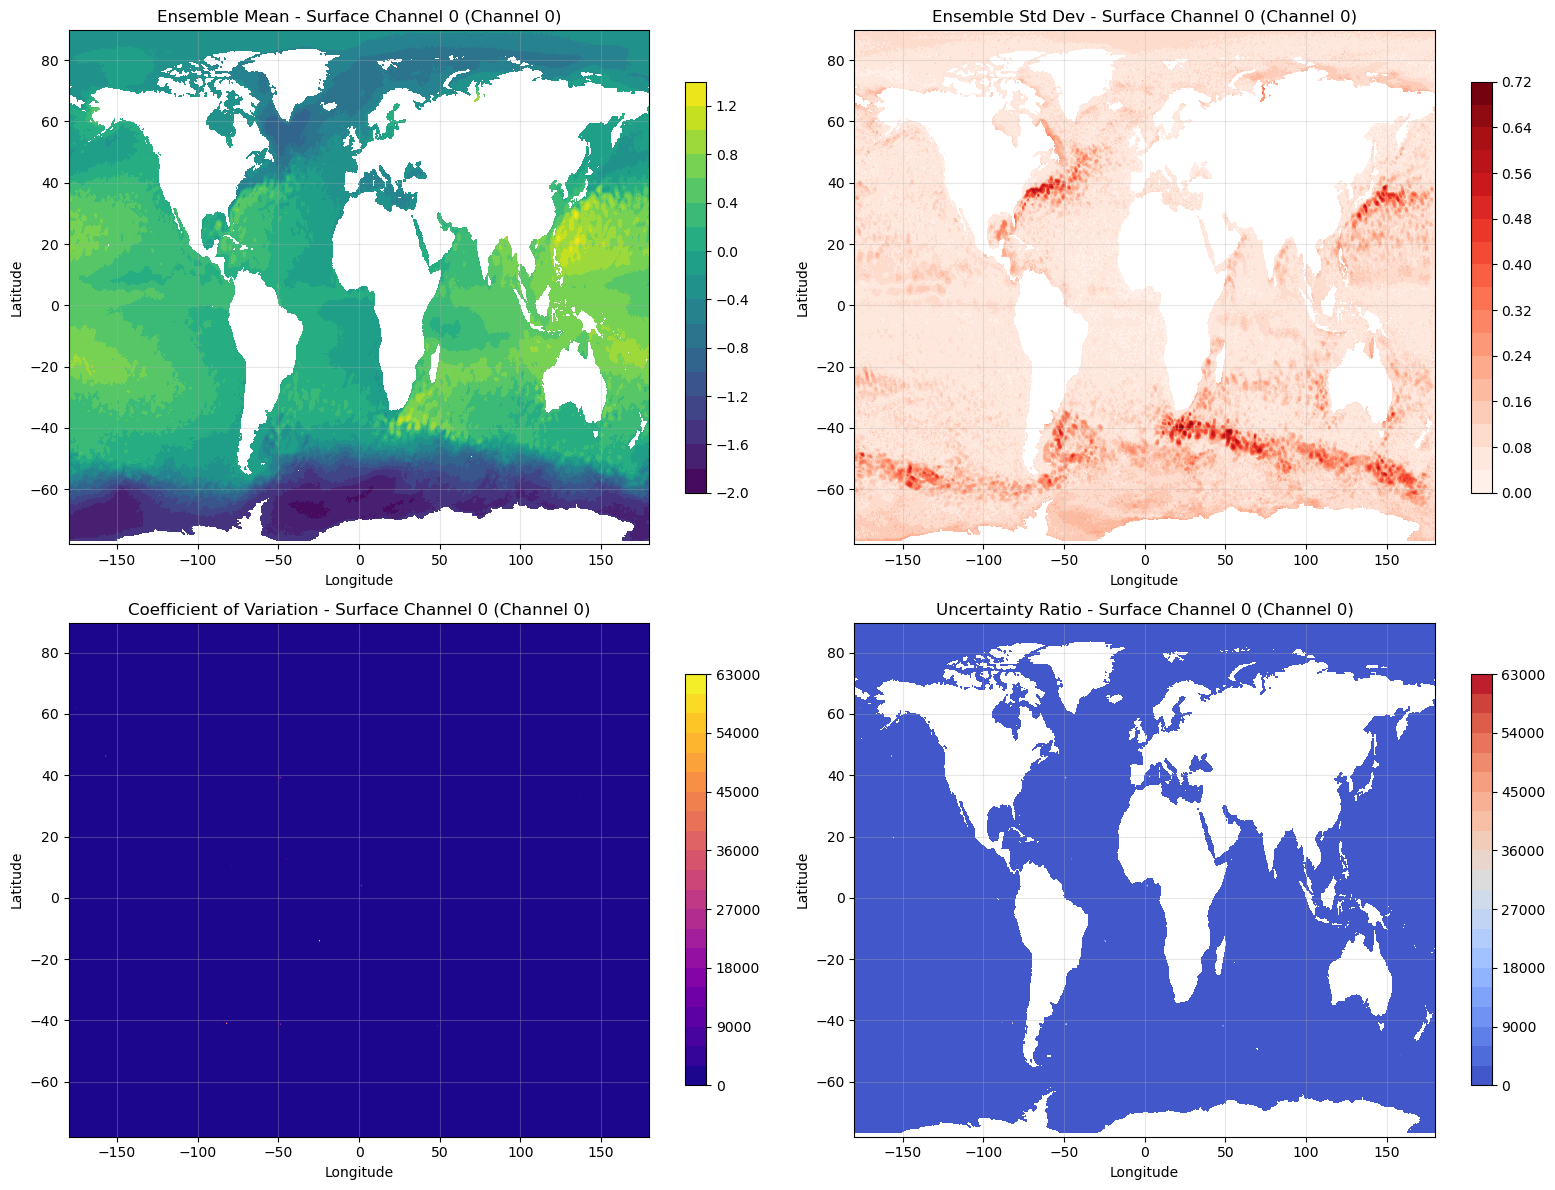


Plotting Surface Channel 1...


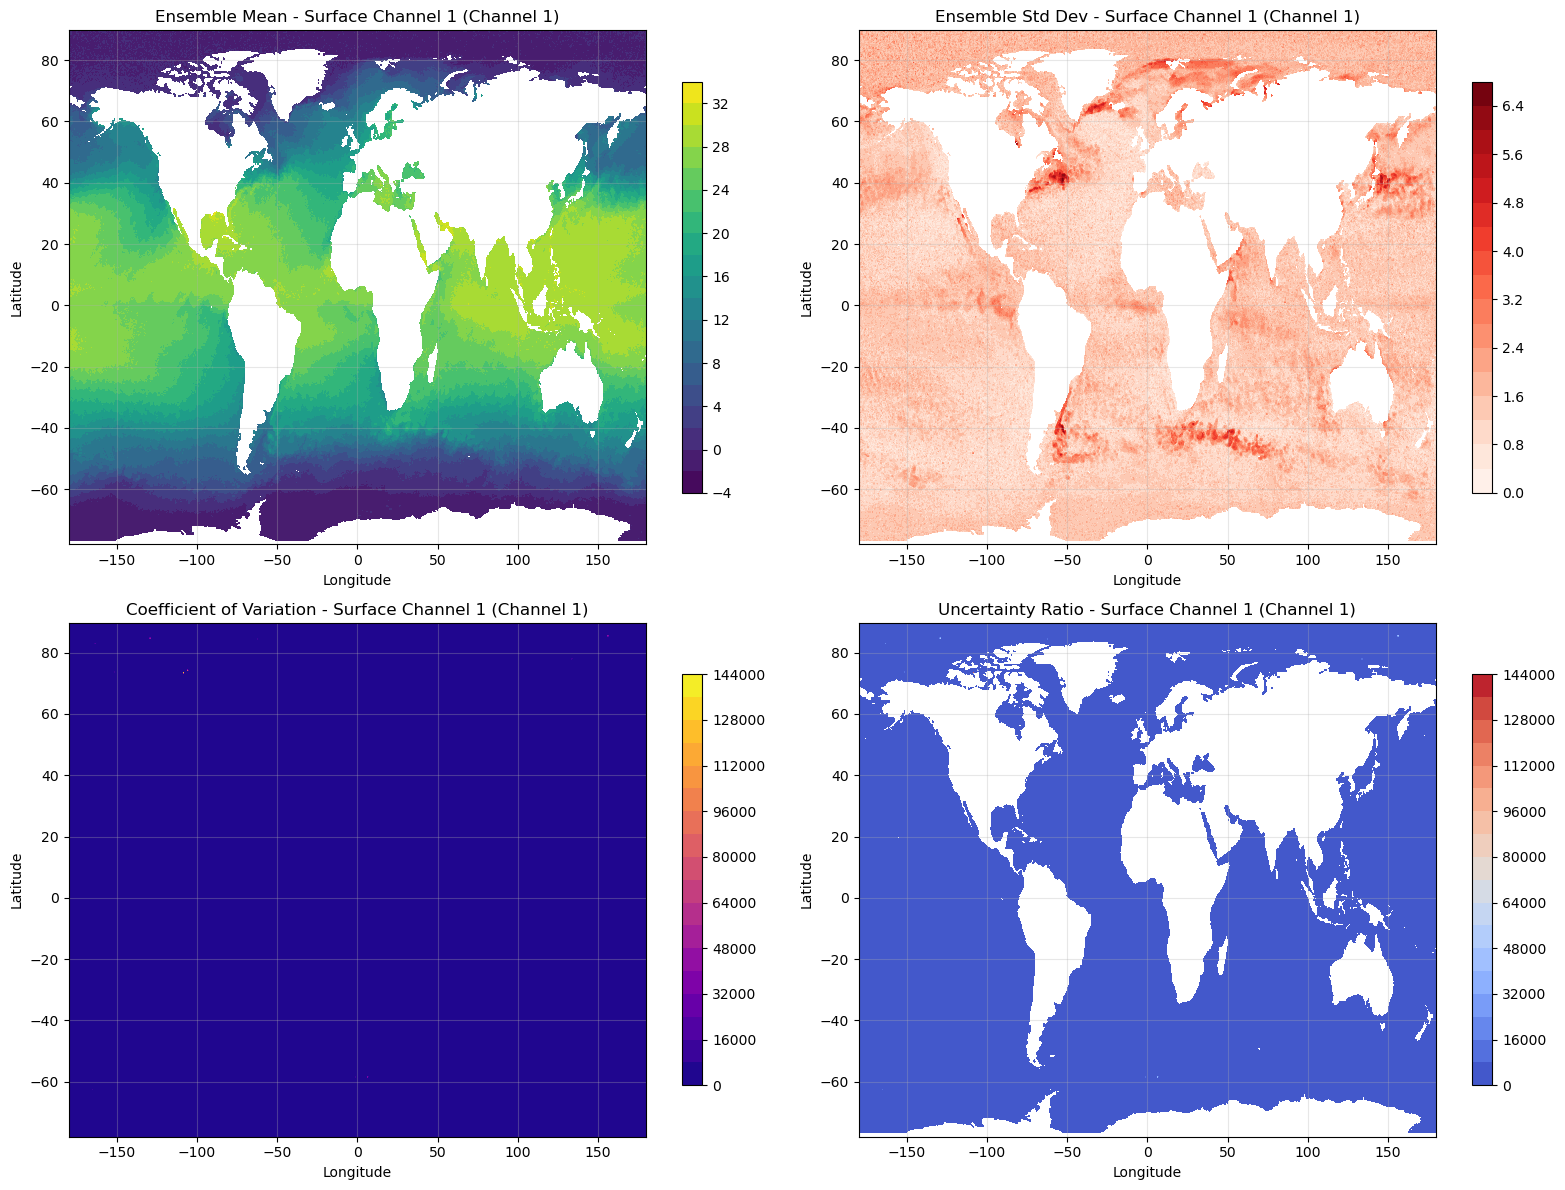


Plotting thetao (shallow L0)...


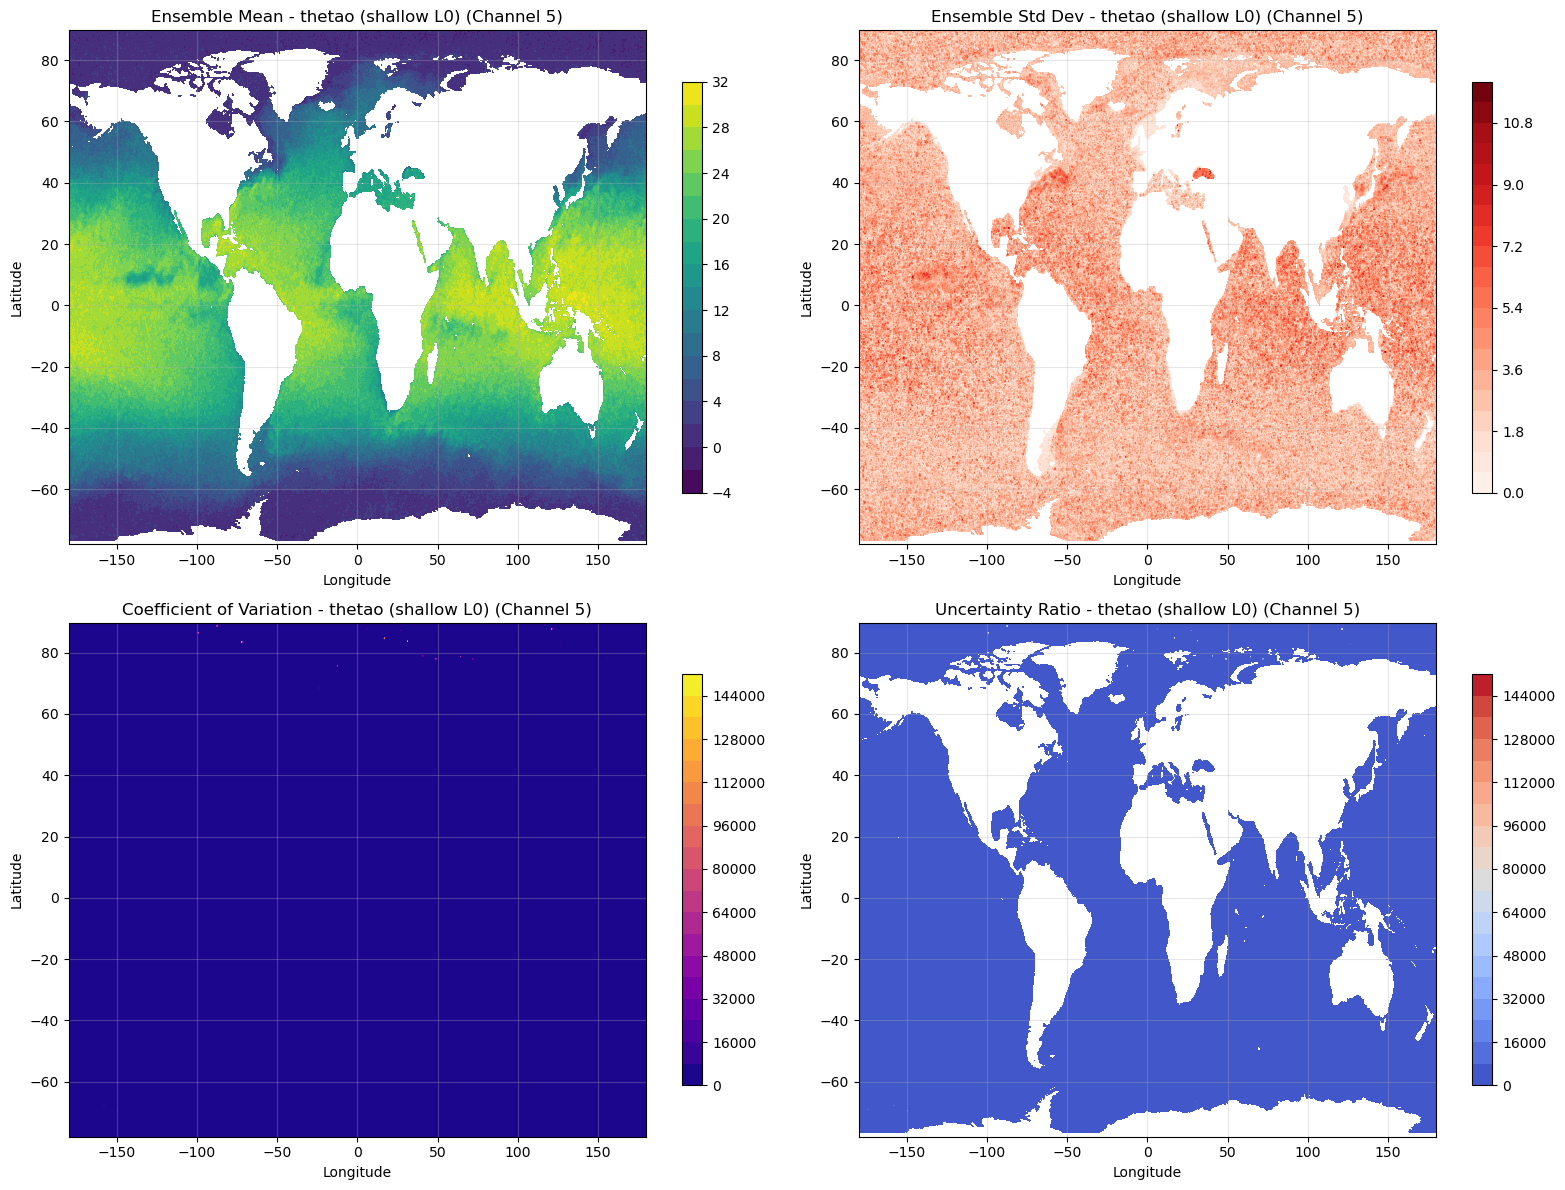


Plotting so (shallow L0)...


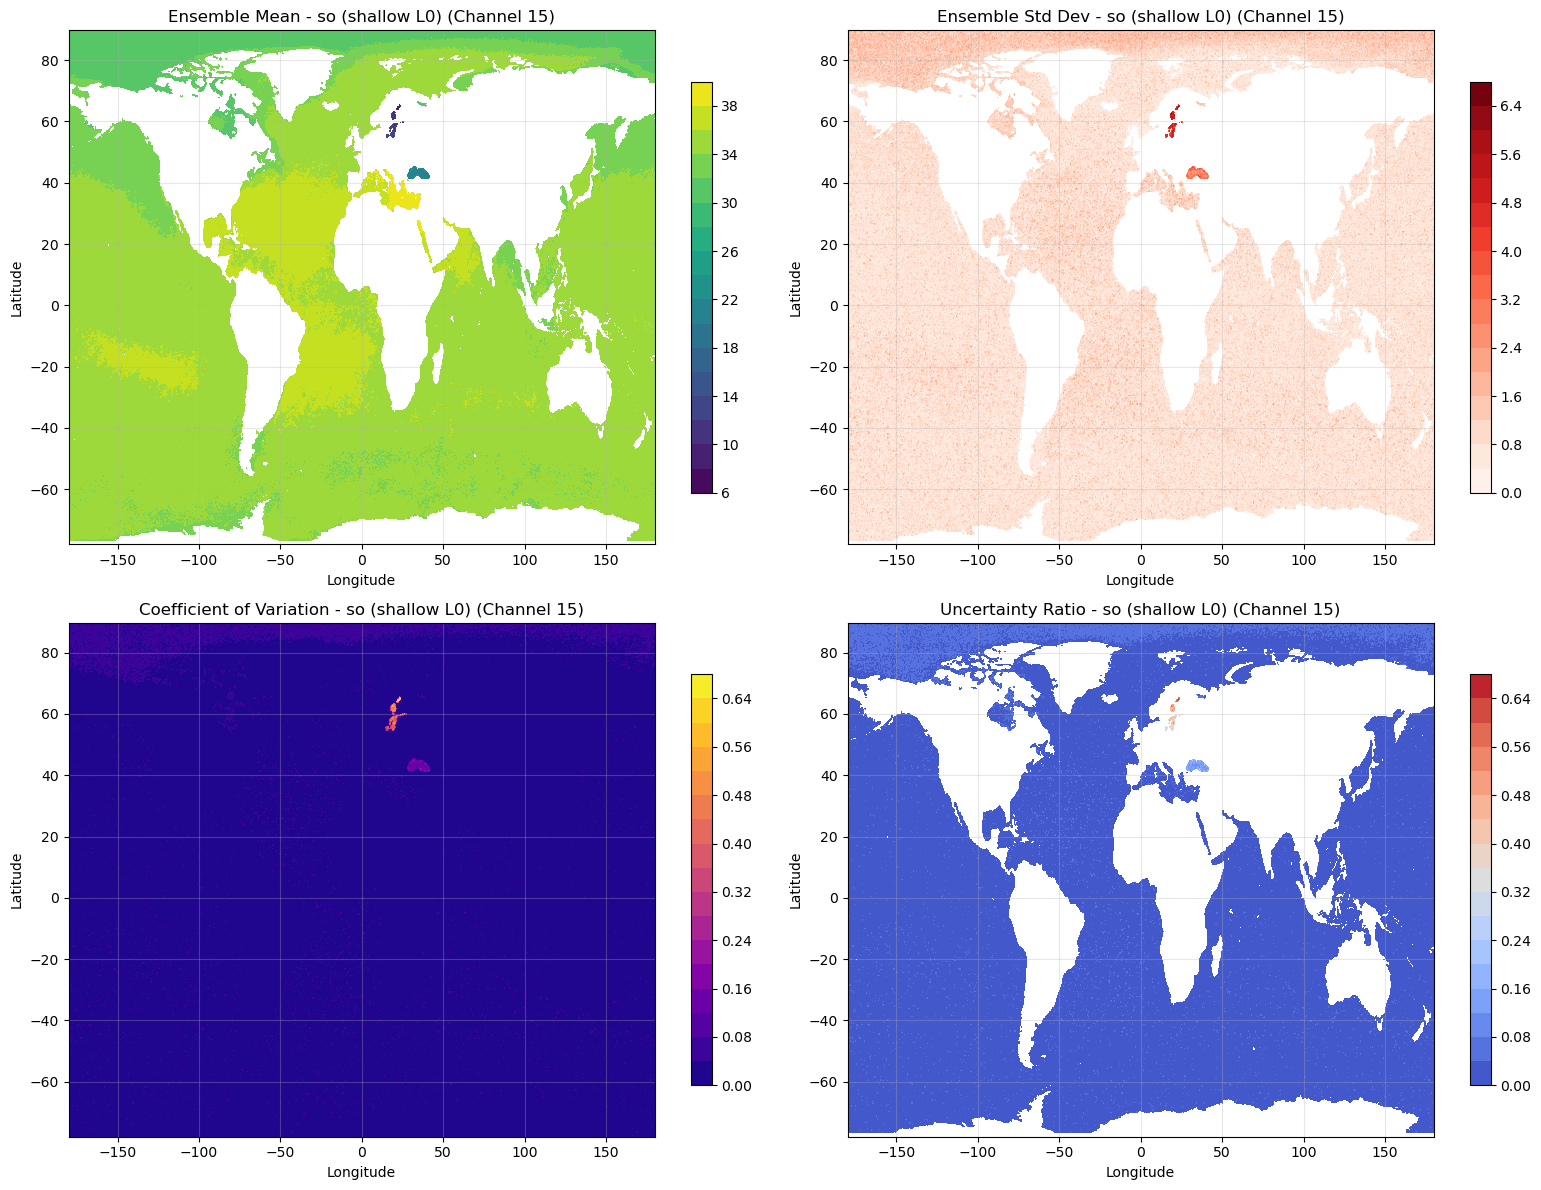


Plotting uo (shallow L0)...


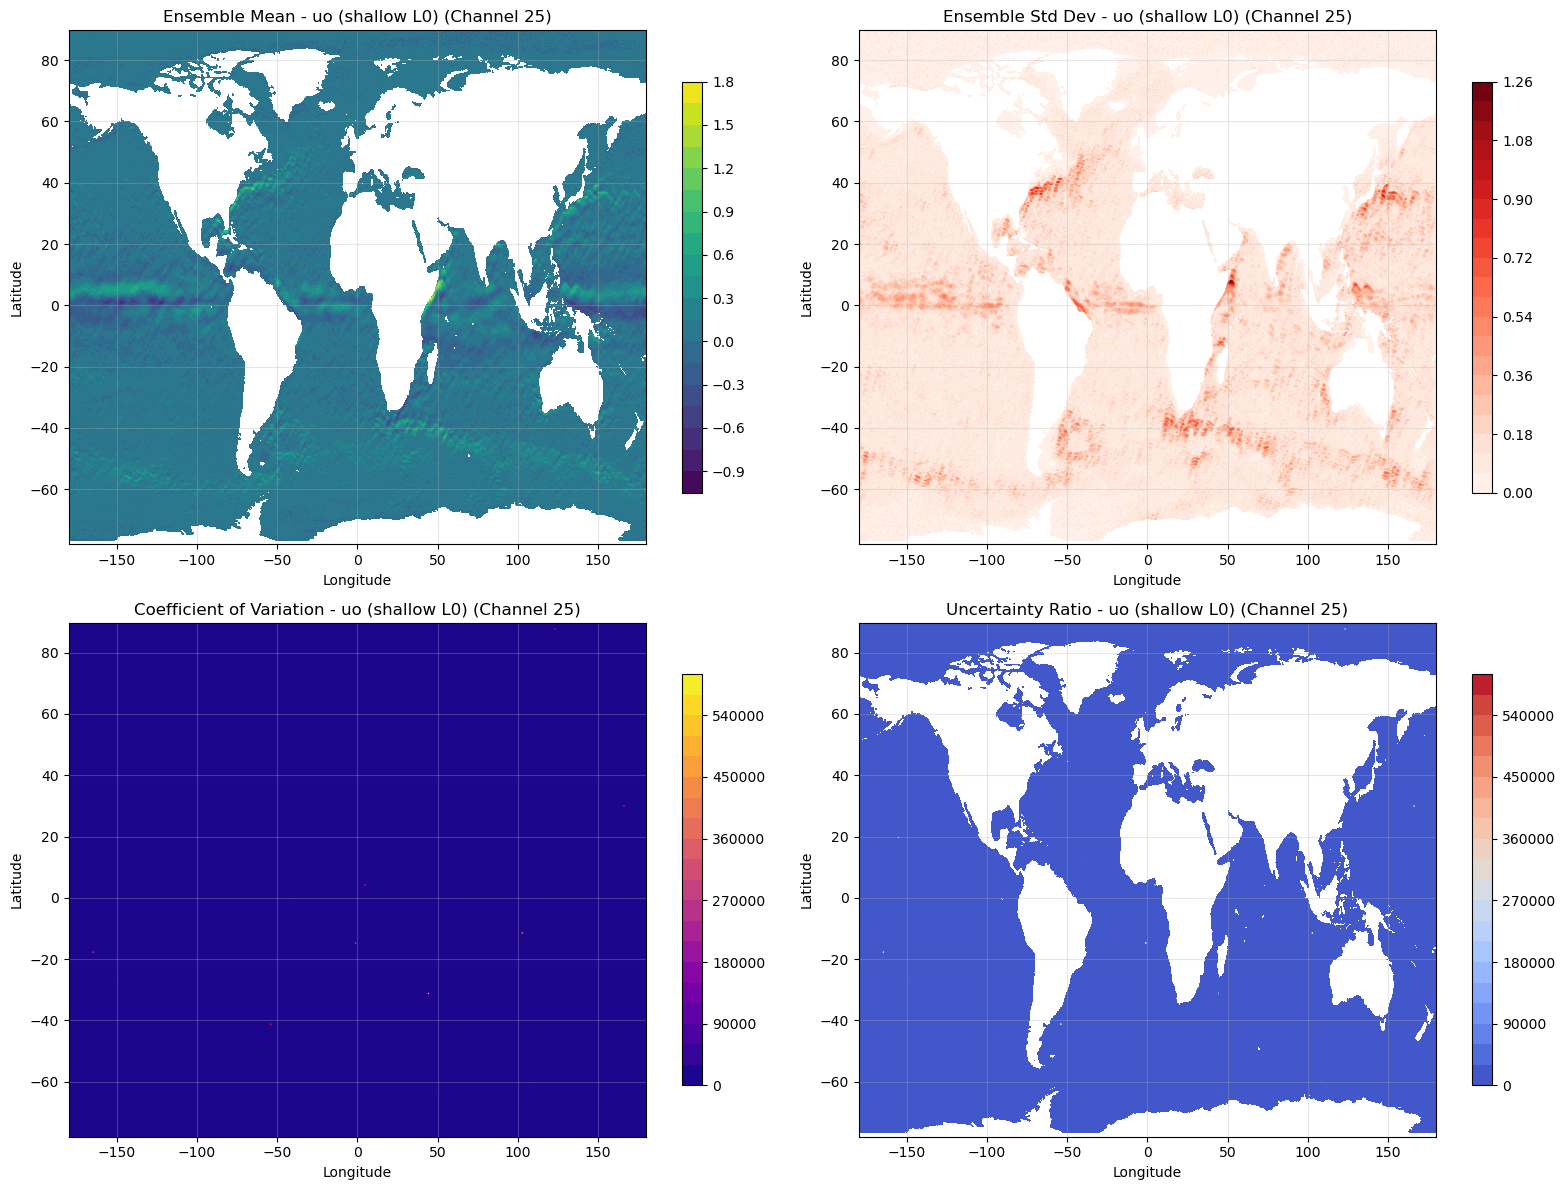


Plotting vo (shallow L0)...


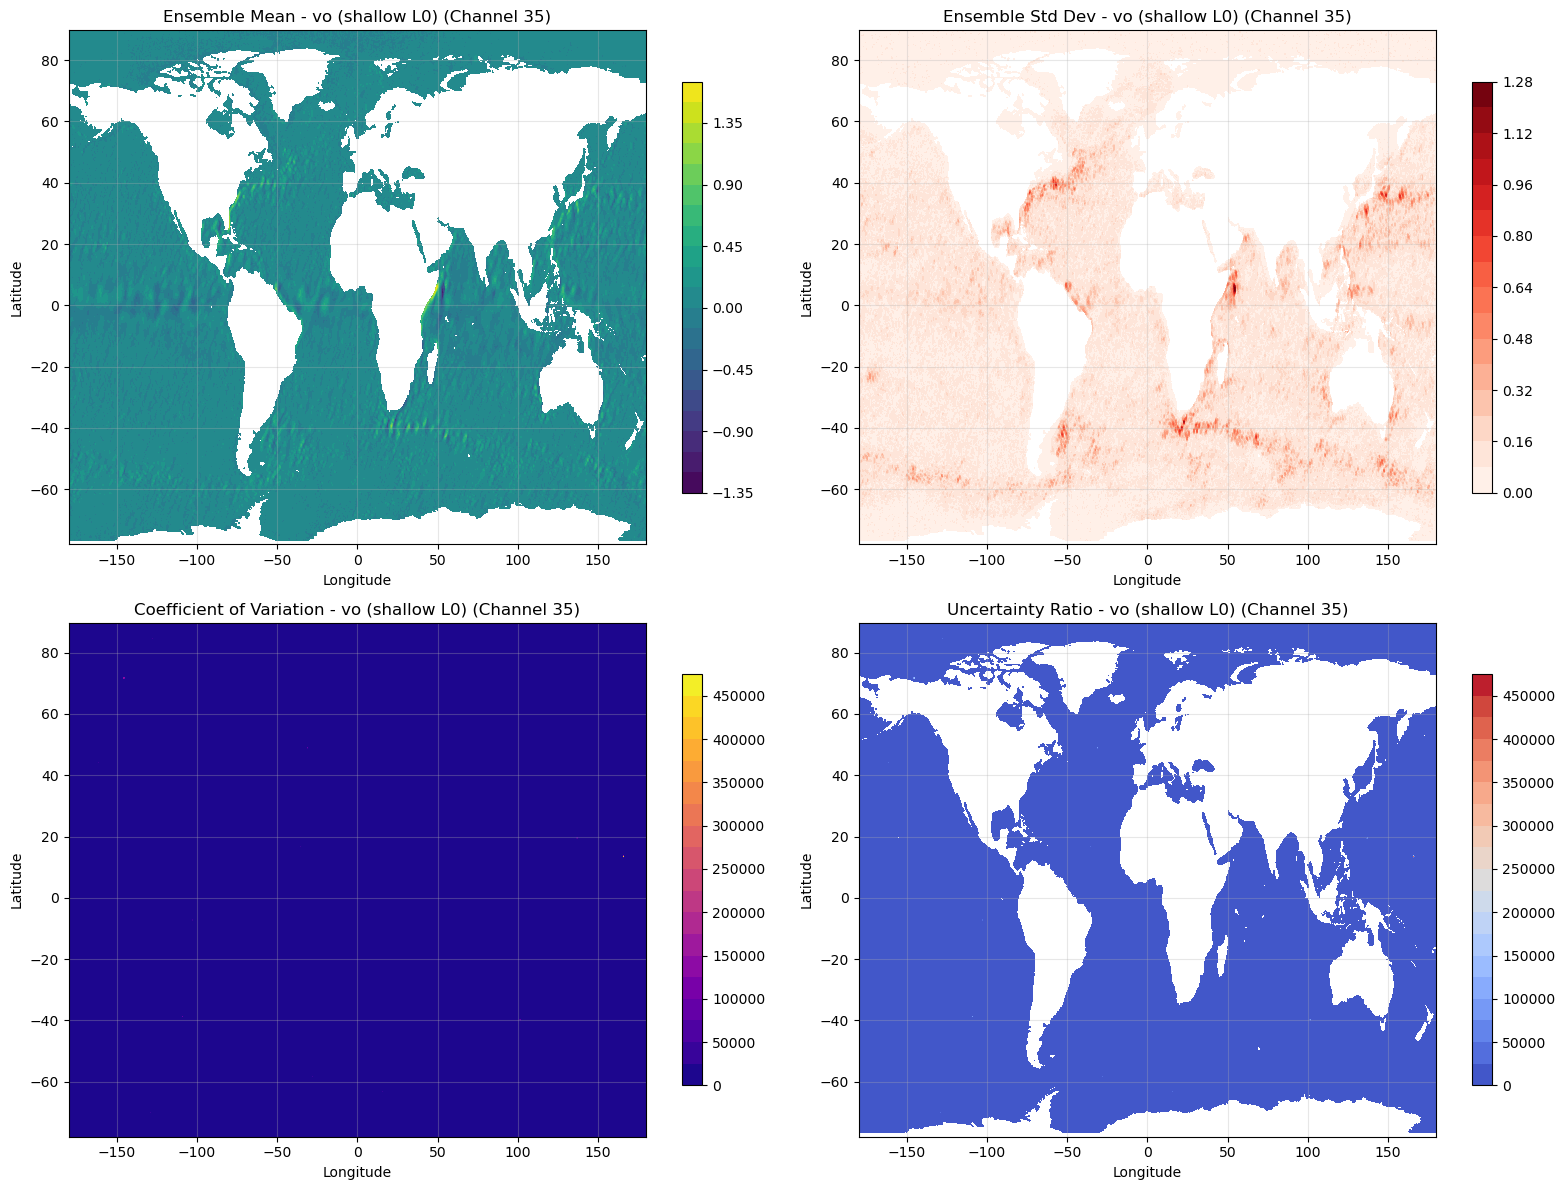

In [130]:
def calculate_ensemble_statistics(ensemble, time_idx=0):
    """
    Calculate ensemble mean and standard deviation.
    
    Parameters:
    ensemble: Dictionary of ensemble datasets
    time_idx: Time index to analyze
    
    Returns:
    ens_mean: xarray Dataset with ensemble mean
    ens_std: xarray Dataset with ensemble standard deviation
    """
    # Get all ensemble members
    member_names = list(ensemble.keys())
    print(f"Processing {len(member_names)} ensemble members: {member_names}")
    
    # Stack all ensemble members along a new 'member' dimension
    ensemble_data = []
    for member_name in member_names:
        # Select time and add member dimension
        member_data = ensemble[member_name].isel(time=time_idx).expand_dims('member')
        member_data = member_data.assign_coords(member=[member_name])
        ensemble_data.append(member_data)
    
    # Concatenate along member dimension
    ensemble_stack = xr.concat(ensemble_data, dim='member')
    
    # Calculate statistics
    ens_mean = ensemble_stack.mean(dim='member')
    ens_std = ensemble_stack.std(dim='member')
    
    return ens_mean, ens_std

def plot_global_ensemble_statistics(ens_mean, ens_std, channel_idx=0, 
                                   variable_name="Channel", figsize=(16, 12)):
    """
    Plot global maps of ensemble mean and standard deviation.
    
    Parameters:
    ens_mean: Ensemble mean dataset
    ens_std: Ensemble standard deviation dataset  
    channel_idx: Channel index to plot
    variable_name: Name of the variable for labeling
    figsize: Figure size
    
    Returns:
    fig, axes: matplotlib figure and axes
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize, subplot_kw={'projection': None})
    
    # Get data for the specified channel
    mean_data = ens_mean['data'].isel(ch=channel_idx)
    std_data = ens_std['data'].isel(ch=channel_idx)
    
    # Create coordinate arrays for plotting
    lats = mean_data.lat.values
    lons = mean_data.lon.values
    
    # Plot 1: Ensemble Mean
    im1 = axes[0, 0].contourf(lons, lats, mean_data.values, levels=20, cmap='viridis')
    axes[0, 0].set_title(f'Ensemble Mean - {variable_name} (Channel {channel_idx})')
    axes[0, 0].set_xlabel('Longitude')
    axes[0, 0].set_ylabel('Latitude')
    plt.colorbar(im1, ax=axes[0, 0], shrink=0.8)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Ensemble Standard Deviation
    im2 = axes[0, 1].contourf(lons, lats, std_data.values, levels=20, cmap='Reds')
    axes[0, 1].set_title(f'Ensemble Std Dev - {variable_name} (Channel {channel_idx})')
    axes[0, 1].set_xlabel('Longitude')
    axes[0, 1].set_ylabel('Latitude')
    plt.colorbar(im2, ax=axes[0, 1], shrink=0.8)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Coefficient of Variation (Std/Mean)
    # Avoid division by zero
    cv_data = np.where(np.abs(mean_data.values) > 1e-10, 
                       std_data.values / np.abs(mean_data.values), 0)
    im3 = axes[1, 0].contourf(lons, lats, cv_data, levels=20, cmap='plasma')
    axes[1, 0].set_title(f'Coefficient of Variation - {variable_name} (Channel {channel_idx})')
    axes[1, 0].set_xlabel('Longitude')
    axes[1, 0].set_ylabel('Latitude')
    plt.colorbar(im3, ax=axes[1, 0], shrink=0.8)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Uncertainty ratio (Std/|Mean|) with different colormap
    uncertainty_ratio = np.where(np.abs(mean_data.values) > 1e-10,
                                std_data.values / np.abs(mean_data.values), np.nan)
    im4 = axes[1, 1].contourf(lons, lats, uncertainty_ratio, levels=20, cmap='coolwarm')
    axes[1, 1].set_title(f'Uncertainty Ratio - {variable_name} (Channel {channel_idx})')
    axes[1, 1].set_xlabel('Longitude')
    axes[1, 1].set_ylabel('Latitude')
    plt.colorbar(im4, ax=axes[1, 1], shrink=0.8)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, axes

def plot_ensemble_statistics_summary(ensemble, time_idx=0, channels_to_plot=None):
    """
    Generate comprehensive ensemble statistics plots.
    
    Parameters:
    ensemble: Dictionary of ensemble datasets
    time_idx: Time index to analyze
    channels_to_plot: List of channel indices to plot (if None, plots first few channels)
    """
    # Calculate ensemble statistics
    print("Calculating ensemble statistics...")
    ens_mean, ens_std = calculate_ensemble_statistics(ensemble, time_idx)
    
    # Get depth info for channel naming
    depth_info = get_depth_info()
    
    # Default channels to plot if not specified
    if channels_to_plot is None:
        # Plot some surface channels and some depth channels
        channels_to_plot = [0, 1, 2, 5, 15, 25, 35]  # Mix of surface and depth channels
    
    print(f"Plotting channels: {channels_to_plot}")
    
    # Print overall statistics
    print("\n=== ENSEMBLE STATISTICS SUMMARY ===")
    print(f"Number of ensemble members: {len(ensemble)}")
    print(f"Time index analyzed: {time_idx}")
    print(f"Grid size: {ens_mean.sizes['lat']} x {ens_mean.sizes['lon']}")
    print(f"Number of channels: {ens_mean.sizes['ch']}")
    
    # Calculate global statistics for each channel
    global_stats = {}
    for ch in range(min(10, ens_mean.sizes['ch'])):  # First 10 channels
        mean_ch = ens_mean['data'].isel(ch=ch)
        std_ch = ens_std['data'].isel(ch=ch)
        
        global_stats[ch] = {
            'mean_global_avg': float(mean_ch.mean().values),
            'mean_global_std': float(mean_ch.std().values),
            'std_global_avg': float(std_ch.mean().values),
            'std_global_max': float(std_ch.max().values),
            'uncertainty_avg': float((std_ch / (np.abs(mean_ch) + 1e-10)).mean().values)
        }
    
    # Print statistics table
    print(f"\n{'Channel':<8} {'Mean_Avg':<10} {'Mean_Std':<10} {'Std_Avg':<10} {'Std_Max':<10} {'Uncert_Avg':<12}")
    print("-" * 70)
    for ch, stats in global_stats.items():
        print(f"{ch:<8} {stats['mean_global_avg']:<10.4f} {stats['mean_global_std']:<10.4f} "
              f"{stats['std_global_avg']:<10.4f} {stats['std_global_max']:<10.4f} {stats['uncertainty_avg']:<12.4f}")
    
    # Create plots for selected channels
    for ch_idx in channels_to_plot:
        if ch_idx < ens_mean.sizes['ch']:
            # Determine variable name
            if ch_idx in depth_info['surface_channels']:
                var_name = f"Surface Channel {ch_idx}"
            else:
                # Find which depth variable this channel belongs to
                for var_name_key, ch_list in depth_info['channel_mapping'].items():
                    if ch_idx in ch_list:
                        level_in_var = ch_list.index(ch_idx)
                        depth_group = "shallow" if level_in_var < 10 else "deep"
                        level_num = level_in_var % 10
                        var_name = f"{var_name_key} ({depth_group} L{level_num})"
                        break
                else:
                    var_name = f"Channel {ch_idx}"
            
            print(f"\nPlotting {var_name}...")
            fig, axes = plot_global_ensemble_statistics(ens_mean, ens_std, ch_idx, var_name)
            plt.show()
    
    return ens_mean, ens_std, global_stats

# Calculate and plot ensemble statistics
print("=== ENSEMBLE STATISTICS ANALYSIS ===")
ens_mean, ens_std, stats_summary = plot_ensemble_statistics_summary(
    ensemble, 
    time_idx=time_idx,
    channels_to_plot=[0, 1, 5, 15, 25, 35]  # Surface + depth channels
)

## Multi-variate correlation ##



## Multi-variate Correlation Analysis

This section analyzes correlations between different variables/channels in the ensemble data. The analysis includes:

### 1. **Surface Variables Correlation**
- Analysis of correlations between surface channels (0-4)
- Shows how different surface variables relate to each other across all ensemble members

### 2. **Same Depth Level Correlation** 
- Analysis of correlations between the same depth level across different variables
- Compares thetao, so, uo, vo at identical depth levels
- Helps identify physical relationships between temperature, salinity, and velocities

### 3. **Regional Correlation Analysis**
- Examines correlations within specific oceanic regions (Gulf Stream, Agulhas, etc.)
- Shows how variable relationships change in different dynamical zones

### 4. **Depth-wise Correlation Comparison**
- Compares how correlations between variables evolve with depth
- Identifies depth-dependent physical processes

### Key Features:
- **Correlation Types**: Pearson (linear) and Spearman (non-linear) correlations
- **Standardization**: Optional standardization of variables before correlation
- **Statistical Analysis**: Mean, std, and distribution of correlation coefficients
- **Visualization**: Heatmaps, scatter plots, and distribution plots
- **Physical Interpretation**: Focus on oceanographic variables and their relationships

### Data Structure:
- **Surface Channels (0-4)**: Surface oceanographic variables
- **Depth Channels (5-84)**: Organized as 4 variables × 20 depth levels
  - Variables: thetao (temperature), so (salinity), uo (u-velocity), vo (v-velocity)
  - 10 shallow + 10 deep levels per variable

In [136]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt

def standardize_data(data):
    """
    Standardize data to have zero mean and unit variance (equivalent to sklearn's StandardScaler).
    
    Parameters:
    data: numpy array of shape (n_samples, n_features)
    
    Returns:
    standardized_data: numpy array with same shape, standardized
    """
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    # Avoid division by zero for constant features
    std = np.where(std == 0, 1, std)
    return (data - mean) / std

def calculate_multivariate_correlations(ensemble, time_idx=0, depth_level=None, 
                                      correlation_type='pearson', standardize=True):
    """
    Calculate multi-variate correlations between different variables/channels.
    
    Parameters:
    ensemble: Dictionary of ensemble datasets
    time_idx: Time index to analyze
    depth_level: If None, analyzes surface channels. If int, analyzes same depth level across variables
    correlation_type: 'pearson' or 'spearman'
    standardize: Whether to standardize variables before correlation
    
    Returns:
    correlation_matrix: Correlation matrix as pandas DataFrame
    variable_names: List of variable names corresponding to matrix indices
    """
    depth_info = get_depth_info()
    
    # Determine which channels to analyze
    if depth_level is None:
        # Surface analysis - use surface channels
        channels_to_analyze = depth_info['surface_channels']
        analysis_type = "Surface"
        var_names = [f"Surface_Ch_{ch}" for ch in channels_to_analyze]
    else:
        # Same depth level analysis across all variables
        channels_to_analyze = []
        var_names = []
        
        for var_idx, var_name in enumerate(depth_info['variable_names']):
            var_channels = depth_info['channel_mapping'][var_name]
            if depth_level < len(var_channels):
                ch = var_channels[depth_level]
                channels_to_analyze.append(ch)
                level_group = "shallow" if depth_level < 10 else "deep"
                level_num = depth_level % 10
                var_names.append(f"{var_name}_{level_group}_L{level_num}")
        
        analysis_type = f"Depth_Level_{depth_level}"
    
    print(f"Analyzing {analysis_type} correlations for channels: {channels_to_analyze}")
    print(f"Variable names: {var_names}")
    
    # Collect data from all ensemble members
    all_member_data = []
    member_names = list(ensemble.keys())
    
    for member_name in member_names:
        ds = ensemble[member_name].isel(time=time_idx)
        
        # Extract data for each channel and flatten spatial dimensions
        member_data = []
        for ch in channels_to_analyze:
            if ch < ds.sizes['ch']:
                channel_data = ds['data'].isel(ch=ch).values.flatten()
                member_data.append(channel_data)
            else:
                print(f"Warning: Channel {ch} not found in {member_name}")
                member_data.append(np.full(ds['data'].isel(ch=0).size, np.nan))
        
        # Stack channel data: shape = (n_channels, n_spatial_points)
        member_array = np.array(member_data)
        all_member_data.append(member_array)
    
    # Combine all members: shape = (n_members, n_channels, n_spatial_points)
    combined_data = np.array(all_member_data)
    
    # Reshape to (n_samples, n_variables) where samples = members × spatial_points
    n_members, n_channels, n_spatial = combined_data.shape
    reshaped_data = combined_data.transpose(0, 2, 1).reshape(-1, n_channels)
    
    # Remove NaN values
    valid_mask = ~np.isnan(reshaped_data).any(axis=1)
    clean_data = reshaped_data[valid_mask]
    
    print(f"Data shape after preprocessing: {clean_data.shape}")
    print(f"Valid samples: {np.sum(valid_mask)} / {len(valid_mask)}")
    
    # Standardize if requested
    if standardize:
        clean_data = standardize_data(clean_data)
    
    # Calculate correlation matrix
    if correlation_type == 'pearson':
        corr_matrix = np.corrcoef(clean_data.T)
    elif correlation_type == 'spearman':
        # Calculate Spearman correlation
        from scipy.stats import spearmanr
        corr_matrix, _ = spearmanr(clean_data, axis=0)
    else:
        raise ValueError("correlation_type must be 'pearson' or 'spearman'")
    
    # Convert to pandas DataFrame for easier handling
    corr_df = pd.DataFrame(corr_matrix, index=var_names, columns=var_names)
    
    return corr_df, var_names, clean_data

def plot_correlation_heatmap(corr_df, title="Multi-variate Correlation", 
                           figsize=(10, 8), cmap='RdBu_r', save_path=None):
    """
    Plot correlation matrix as a heatmap.
    
    Parameters:
    corr_df: Correlation matrix as pandas DataFrame
    title: Plot title
    figsize: Figure size
    cmap: Colormap
    save_path: Path to save figure (optional)
    
    Returns:
    fig, ax: matplotlib figure and axes
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create heatmap
    sns.heatmap(corr_df, annot=True, cmap=cmap, center=0, 
                square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Correlation heatmap saved to: {save_path}")
    
    return fig, ax

def analyze_correlation_patterns(corr_df, threshold=0.5):
    """
    Analyze and summarize correlation patterns.
    
    Parameters:
    corr_df: Correlation matrix as pandas DataFrame
    threshold: Correlation threshold for identifying strong correlations
    
    Returns:
    analysis_results: Dictionary with analysis results
    """
    # Extract upper triangle (avoid diagonal and duplicates)
    mask = np.triu(np.ones_like(corr_df.values, dtype=bool), k=1)
    upper_triangle = corr_df.values[mask]
    
    # Get variable pairs for upper triangle
    var_names = corr_df.columns.tolist()
    pairs = []
    correlations = []
    
    for i in range(len(var_names)):
        for j in range(i+1, len(var_names)):
            pairs.append((var_names[i], var_names[j]))
            correlations.append(corr_df.iloc[i, j])
    
    # Create summary DataFrame
    corr_summary = pd.DataFrame({
        'Variable_1': [pair[0] for pair in pairs],
        'Variable_2': [pair[1] for pair in pairs],
        'Correlation': correlations,
        'Abs_Correlation': [abs(corr) for corr in correlations]
    })
    
    # Sort by absolute correlation
    corr_summary = corr_summary.sort_values('Abs_Correlation', ascending=False)
    
    # Identify strong correlations
    strong_correlations = corr_summary[corr_summary['Abs_Correlation'] >= threshold]
    
    # Statistical summary
    analysis_results = {
        'n_variables': len(var_names),
        'n_pairs': len(correlations),
        'mean_correlation': np.mean(upper_triangle),
        'std_correlation': np.std(upper_triangle),
        'max_correlation': np.max(upper_triangle),
        'min_correlation': np.min(upper_triangle),
        'strong_positive': len(strong_correlations[strong_correlations['Correlation'] >= threshold]),
        'strong_negative': len(strong_correlations[strong_correlations['Correlation'] <= -threshold]),
        'correlation_summary': corr_summary,
        'strong_correlations': strong_correlations
    }
    
    return analysis_results

def plot_correlation_distribution(corr_df, title="Correlation Distribution", figsize=(12, 5)):
    """
    Plot distribution of correlation values.
    
    Parameters:
    corr_df: Correlation matrix as pandas DataFrame
    title: Plot title
    figsize: Figure size
    
    Returns:
    fig, axes: matplotlib figure and axes
    """
    # Extract upper triangle correlations (exclude diagonal)
    mask = np.triu(np.ones_like(corr_df.values, dtype=bool), k=1)
    correlations = corr_df.values[mask]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Histogram
    ax1.hist(correlations, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(np.mean(correlations), color='red', linestyle='--', 
                label=f'Mean: {np.mean(correlations):.3f}')
    ax1.axvline(np.median(correlations), color='orange', linestyle='--', 
                label=f'Median: {np.median(correlations):.3f}')
    ax1.set_xlabel('Correlation Coefficient')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Correlations')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Box plot
    ax2.boxplot(correlations, vert=True)
    ax2.set_ylabel('Correlation Coefficient')
    ax2.set_title('Correlation Statistics')
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig, (ax1, ax2)

def comprehensive_correlation_analysis(ensemble, time_idx=0, correlation_type='pearson'):
    """
    Perform comprehensive multi-variate correlation analysis.
    
    Parameters:
    ensemble: Dictionary of ensemble datasets
    time_idx: Time index to analyze
    correlation_type: 'pearson' or 'spearman'
    
    Returns:
    results: Dictionary containing all analysis results
    """
    results = {}
    
    print("=== COMPREHENSIVE MULTI-VARIATE CORRELATION ANALYSIS ===\n")
    
    # 1. Surface Variables Correlation
    print("1. SURFACE VARIABLES CORRELATION")
    print("-" * 40)
    surface_corr, surface_vars, surface_data = calculate_multivariate_correlations(
        ensemble, time_idx=time_idx, depth_level=None, correlation_type=correlation_type
    )
    
    surface_analysis = analyze_correlation_patterns(surface_corr, threshold=0.5)
    
    print(f"Surface correlation summary:")
    print(f"  - Mean correlation: {surface_analysis['mean_correlation']:.3f}")
    print(f"  - Std correlation: {surface_analysis['std_correlation']:.3f}")
    print(f"  - Strong positive correlations: {surface_analysis['strong_positive']}")
    print(f"  - Strong negative correlations: {surface_analysis['strong_negative']}")
    
    # Plot surface correlations
    fig1, ax1 = plot_correlation_heatmap(surface_corr, "Surface Variables Correlation")
    plt.show()
    
    fig2, axes2 = plot_correlation_distribution(surface_corr, "Surface Correlation Distribution")
    plt.show()
    
    results['surface'] = {
        'correlation_matrix': surface_corr,
        'analysis': surface_analysis,
        'data': surface_data
    }
    
    # 2. Same Depth Level Analysis for different depths
    depth_levels_to_analyze = [0, 5, 10, 15]  # Different depth levels
    
    for depth_level in depth_levels_to_analyze:
        print(f"\n2.{depth_level+1}. DEPTH LEVEL {depth_level} CORRELATION")
        print("-" * 40)
        
        try:
            depth_corr, depth_vars, depth_data = calculate_multivariate_correlations(
                ensemble, time_idx=time_idx, depth_level=depth_level, 
                correlation_type=correlation_type
            )
            
            depth_analysis = analyze_correlation_patterns(depth_corr, threshold=0.5)
            
            print(f"Depth level {depth_level} correlation summary:")
            print(f"  - Mean correlation: {depth_analysis['mean_correlation']:.3f}")
            print(f"  - Std correlation: {depth_analysis['std_correlation']:.3f}")
            print(f"  - Strong positive correlations: {depth_analysis['strong_positive']}")
            print(f"  - Strong negative correlations: {depth_analysis['strong_negative']}")
            
            # Plot depth correlations
            fig3, ax3 = plot_correlation_heatmap(
                depth_corr, f"Depth Level {depth_level} Variables Correlation"
            )
            plt.show()
            
            results[f'depth_{depth_level}'] = {
                'correlation_matrix': depth_corr,
                'analysis': depth_analysis,
                'data': depth_data
            }
            
        except Exception as e:
            print(f"Error analyzing depth level {depth_level}: {e}")
    
    # 3. Print top correlations summary
    print(f"\n3. TOP CORRELATIONS SUMMARY")
    print("-" * 40)
    
    if 'surface' in results:
        print("Surface - Top 5 correlations:")
        top_surface = results['surface']['analysis']['correlation_summary'].head()
        for idx, row in top_surface.iterrows():
            print(f"  {row['Variable_1']} ↔ {row['Variable_2']}: {row['Correlation']:.3f}")
    
    for depth_level in depth_levels_to_analyze:
        if f'depth_{depth_level}' in results:
            print(f"\nDepth {depth_level} - Top 3 correlations:")
            top_depth = results[f'depth_{depth_level}']['analysis']['correlation_summary'].head(3)
            for idx, row in top_depth.iterrows():
                print(f"  {row['Variable_1']} ↔ {row['Variable_2']}: {row['Correlation']:.3f}")
    
    return results

=== COMPREHENSIVE MULTI-VARIATE CORRELATION ANALYSIS ===

1. SURFACE VARIABLES CORRELATION
----------------------------------------
Analyzing Surface correlations for channels: [0, 1, 2, 3, 4]
Variable names: ['Surface_Ch_0', 'Surface_Ch_1', 'Surface_Ch_2', 'Surface_Ch_3', 'Surface_Ch_4']
Data shape after preprocessing: (3376075, 5)
Valid samples: 3376075 / 4838400
Data shape after preprocessing: (3376075, 5)
Valid samples: 3376075 / 4838400
Surface correlation summary:
  - Mean correlation: 0.097
  - Std correlation: 0.292
  - Strong positive correlations: 1
  - Strong negative correlations: 0
Surface correlation summary:
  - Mean correlation: 0.097
  - Std correlation: 0.292
  - Strong positive correlations: 1
  - Strong negative correlations: 0


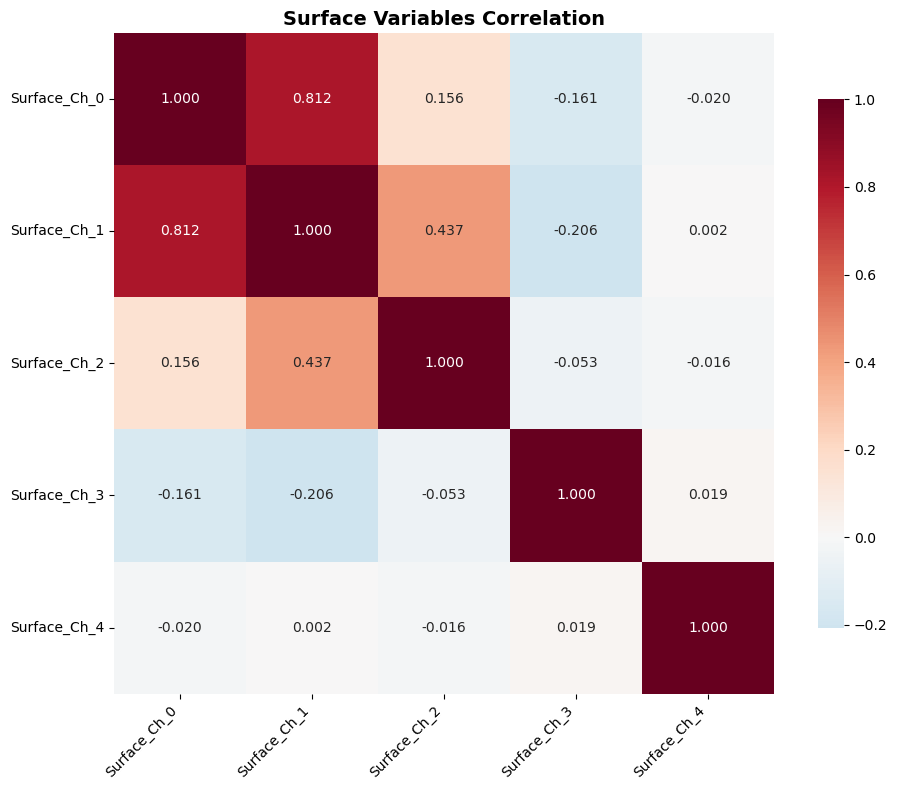

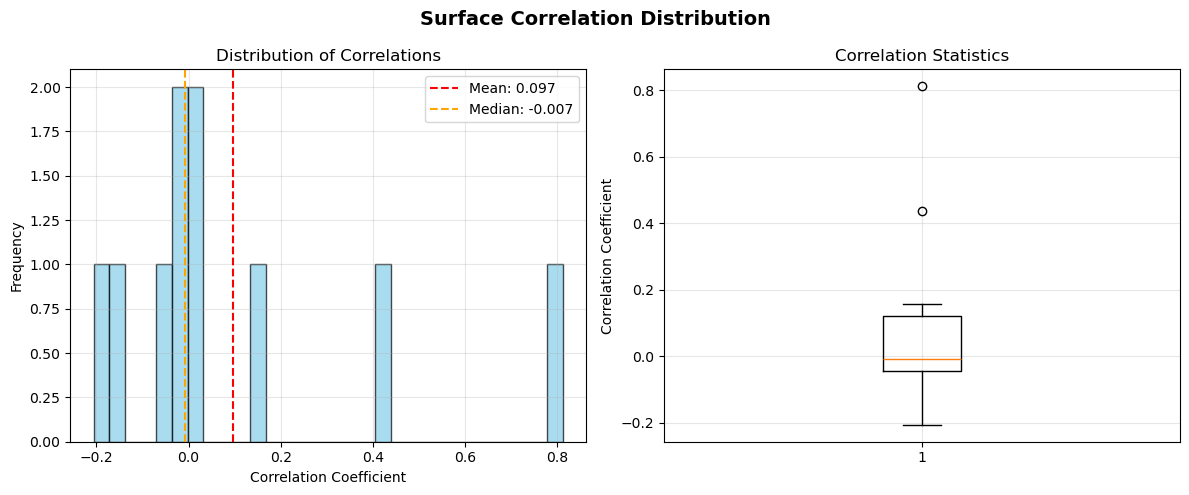


2.1. DEPTH LEVEL 0 CORRELATION
----------------------------------------
Analyzing Depth_Level_0 correlations for channels: [5, 15, 25, 35]
Variable names: ['thetao_shallow_L0', 'so_shallow_L0', 'uo_shallow_L0', 'vo_shallow_L0']
Data shape after preprocessing: (3243975, 4)
Valid samples: 3243975 / 4838400
Data shape after preprocessing: (3243975, 4)
Valid samples: 3243975 / 4838400
Depth level 0 correlation summary:
  - Mean correlation: 0.088
  - Std correlation: 0.223
  - Strong positive correlations: 1
  - Strong negative correlations: 0
Depth level 0 correlation summary:
  - Mean correlation: 0.088
  - Std correlation: 0.223
  - Strong positive correlations: 1
  - Strong negative correlations: 0


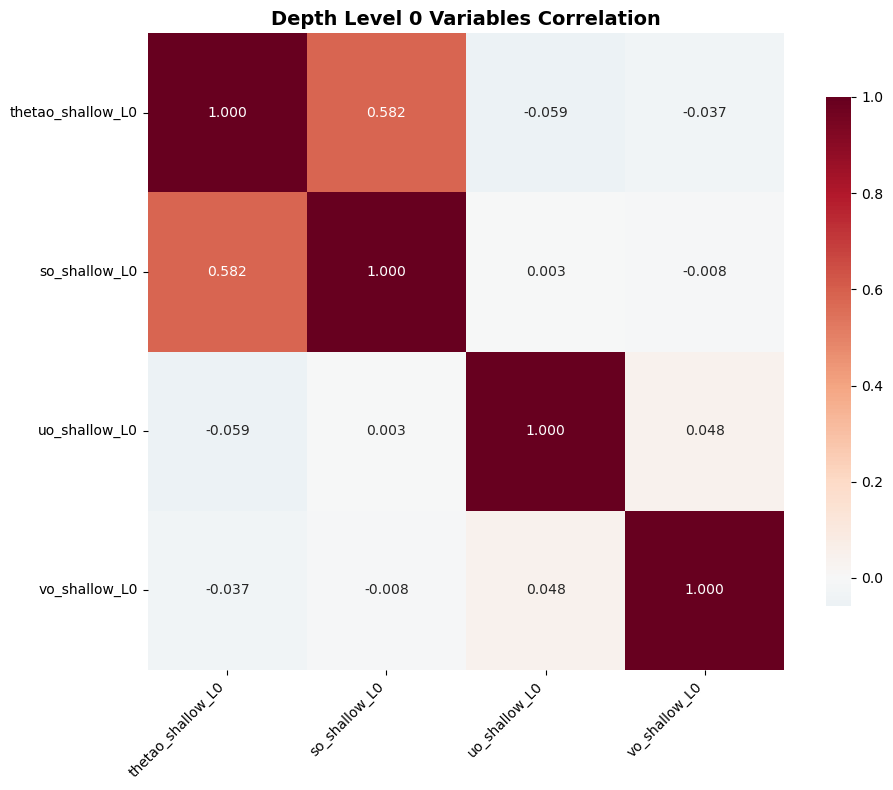


2.6. DEPTH LEVEL 5 CORRELATION
----------------------------------------
Analyzing Depth_Level_5 correlations for channels: [10, 20, 30, 40]
Variable names: ['thetao_shallow_L5', 'so_shallow_L5', 'uo_shallow_L5', 'vo_shallow_L5']
Data shape after preprocessing: (2980035, 4)
Valid samples: 2980035 / 4838400
Data shape after preprocessing: (2980035, 4)
Valid samples: 2980035 / 4838400
Depth level 5 correlation summary:
  - Mean correlation: 0.068
  - Std correlation: 0.132
  - Strong positive correlations: 0
  - Strong negative correlations: 0
Depth level 5 correlation summary:
  - Mean correlation: 0.068
  - Std correlation: 0.132
  - Strong positive correlations: 0
  - Strong negative correlations: 0


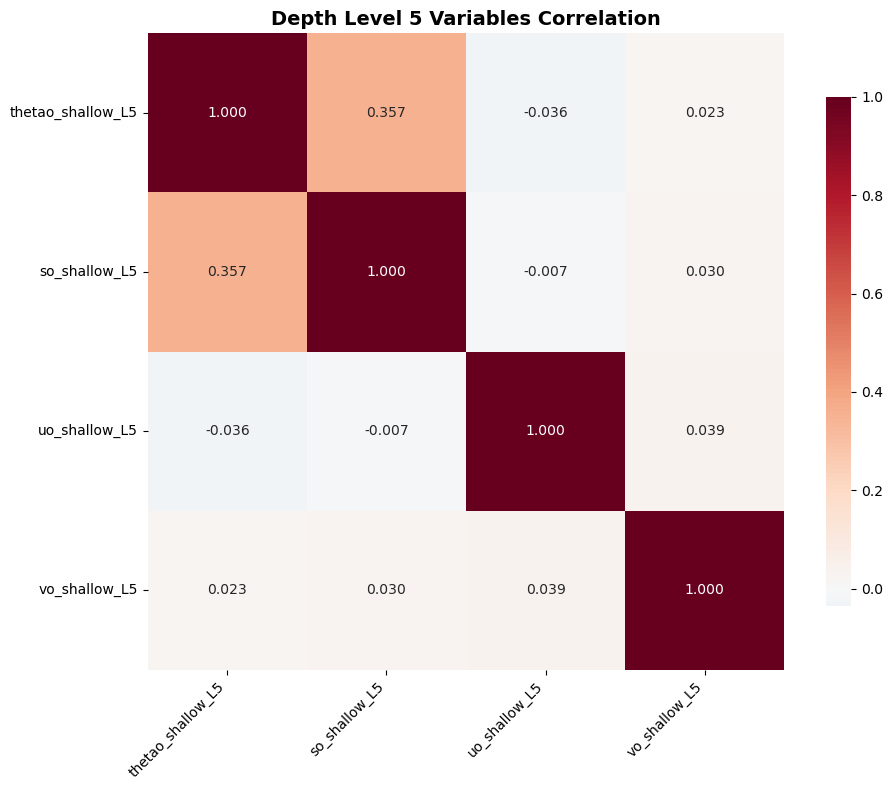


2.11. DEPTH LEVEL 10 CORRELATION
----------------------------------------
Analyzing Depth_Level_10 correlations for channels: [45, 55, 65, 75]
Variable names: ['thetao_deep_L0', 'so_deep_L0', 'uo_deep_L0', 'vo_deep_L0']
Data shape after preprocessing: (2871810, 4)
Valid samples: 2871810 / 4838400
Data shape after preprocessing: (2871810, 4)
Valid samples: 2871810 / 4838400
Depth level 10 correlation summary:
  - Mean correlation: 0.000
  - Std correlation: 0.083
  - Strong positive correlations: 0
  - Strong negative correlations: 0
Depth level 10 correlation summary:
  - Mean correlation: 0.000
  - Std correlation: 0.083
  - Strong positive correlations: 0
  - Strong negative correlations: 0


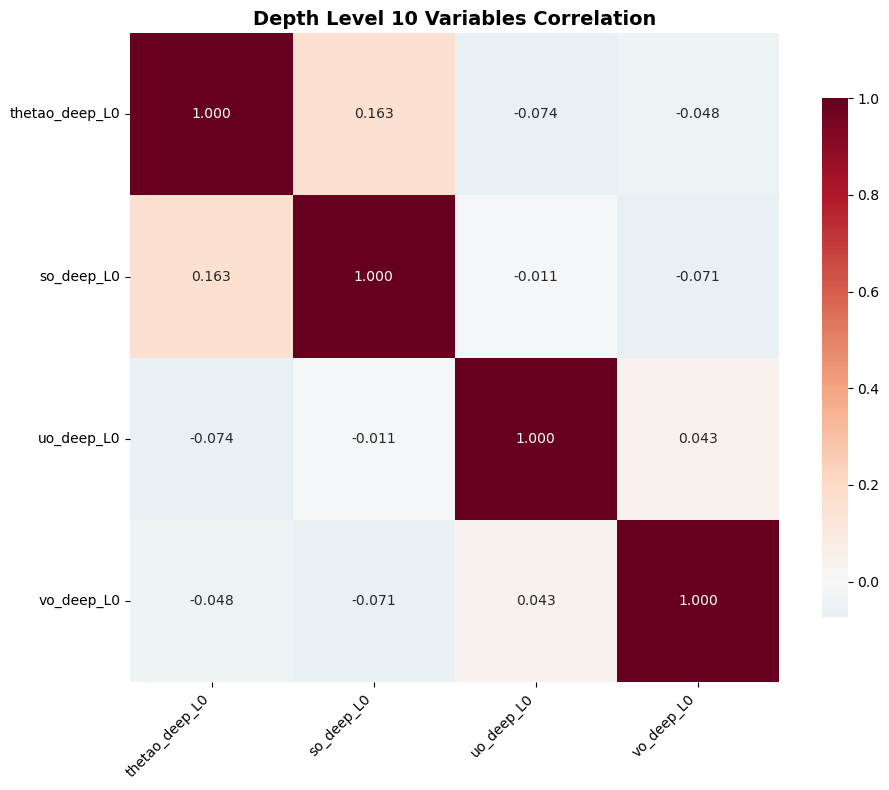


2.16. DEPTH LEVEL 15 CORRELATION
----------------------------------------
Analyzing Depth_Level_15 correlations for channels: [50, 60, 70, 80]
Variable names: ['thetao_deep_L5', 'so_deep_L5', 'uo_deep_L5', 'vo_deep_L5']
Data shape after preprocessing: (1868270, 4)
Valid samples: 1868270 / 4838400
Data shape after preprocessing: (1868270, 4)
Valid samples: 1868270 / 4838400
Depth level 15 correlation summary:
  - Mean correlation: 0.045
  - Std correlation: 0.138
  - Strong positive correlations: 0
  - Strong negative correlations: 0
Depth level 15 correlation summary:
  - Mean correlation: 0.045
  - Std correlation: 0.138
  - Strong positive correlations: 0
  - Strong negative correlations: 0


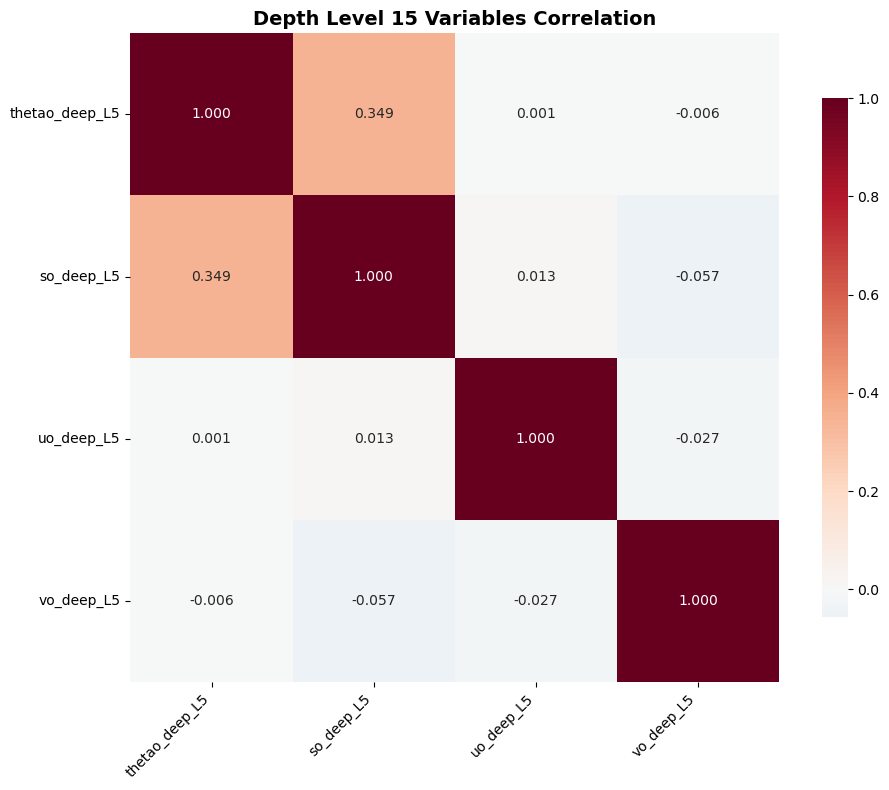


3. TOP CORRELATIONS SUMMARY
----------------------------------------
Surface - Top 5 correlations:
  Surface_Ch_0 ↔ Surface_Ch_1: 0.812
  Surface_Ch_1 ↔ Surface_Ch_2: 0.437
  Surface_Ch_1 ↔ Surface_Ch_3: -0.206
  Surface_Ch_0 ↔ Surface_Ch_3: -0.161
  Surface_Ch_0 ↔ Surface_Ch_2: 0.156

Depth 0 - Top 3 correlations:
  thetao_shallow_L0 ↔ so_shallow_L0: 0.582
  thetao_shallow_L0 ↔ uo_shallow_L0: -0.059
  uo_shallow_L0 ↔ vo_shallow_L0: 0.048

Depth 5 - Top 3 correlations:
  thetao_shallow_L5 ↔ so_shallow_L5: 0.357
  uo_shallow_L5 ↔ vo_shallow_L5: 0.039
  thetao_shallow_L5 ↔ uo_shallow_L5: -0.036

Depth 10 - Top 3 correlations:
  thetao_deep_L0 ↔ so_deep_L0: 0.163
  thetao_deep_L0 ↔ uo_deep_L0: -0.074
  so_deep_L0 ↔ vo_deep_L0: -0.071

Depth 15 - Top 3 correlations:
  thetao_deep_L5 ↔ so_deep_L5: 0.349
  so_deep_L5 ↔ vo_deep_L5: -0.057
  uo_deep_L5 ↔ vo_deep_L5: -0.027


In [137]:
# Run comprehensive multi-variate correlation analysis
correlation_results = comprehensive_correlation_analysis(
    ensemble, 
    time_idx=time_idx, 
    correlation_type='pearson'  # You can change to 'spearman' for non-linear relationships
)

In [138]:
# Additional specialized correlation analyses

def plot_pairwise_scatter(ensemble, time_idx=0, var1_ch=0, var2_ch=1, 
                         sample_size=1000, figsize=(10, 8)):
    """
    Create scatter plot for two specific variables across all ensemble members.
    
    Parameters:
    ensemble: Dictionary of ensemble datasets
    time_idx: Time index to analyze
    var1_ch: Channel index for first variable
    var2_ch: Channel index for second variable
    sample_size: Number of random spatial points to sample for plotting
    figsize: Figure size
    """
    # Collect data from all ensemble members
    var1_data = []
    var2_data = []
    member_labels = []
    
    for member_name in ensemble.keys():
        ds = ensemble[member_name].isel(time=time_idx)
        
        # Get data for both variables
        v1 = ds['data'].isel(ch=var1_ch).values.flatten()
        v2 = ds['data'].isel(ch=var2_ch).values.flatten()
        
        # Remove NaN values
        valid_mask = ~(np.isnan(v1) | np.isnan(v2))
        v1_clean = v1[valid_mask]
        v2_clean = v2[valid_mask]
        
        # Sample data if too large
        if len(v1_clean) > sample_size:
            indices = np.random.choice(len(v1_clean), sample_size, replace=False)
            v1_clean = v1_clean[indices]
            v2_clean = v2_clean[indices]
        
        var1_data.extend(v1_clean)
        var2_data.extend(v2_clean)
        member_labels.extend([member_name] * len(v1_clean))
    
    # Create DataFrame for plotting
    scatter_df = pd.DataFrame({
        'Variable_1': var1_data,
        'Variable_2': var2_data,
        'Member': member_labels
    })
    
    # Calculate correlation
    correlation = np.corrcoef(var1_data, var2_data)[0, 1]
    
    # Create scatter plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot different members with different colors
    unique_members = list(ensemble.keys())
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_members)))
    
    for i, member in enumerate(unique_members):
        member_data = scatter_df[scatter_df['Member'] == member]
        ax.scatter(member_data['Variable_1'], member_data['Variable_2'], 
                  alpha=0.6, label=member, color=colors[i], s=20)
    
    # Add regression line
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(var1_data, var2_data)
    line_x = np.array([min(var1_data), max(var1_data)])
    line_y = slope * line_x + intercept
    ax.plot(line_x, line_y, 'r--', alpha=0.8, linewidth=2, 
            label=f'Regression Line (r={correlation:.3f})')
    
    ax.set_xlabel(f'Variable Channel {var1_ch}')
    ax.set_ylabel(f'Variable Channel {var2_ch}')
    ax.set_title(f'Pairwise Scatter Plot: Channel {var1_ch} vs Channel {var2_ch}\n'
                f'Correlation: {correlation:.3f}, p-value: {p_value:.3e}')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, ax, correlation

def analyze_regional_correlations(ensemble, regions, time_idx=0, channels_to_analyze=None):
    """
    Analyze correlations within specific oceanic regions.
    
    Parameters:
    ensemble: Dictionary of ensemble datasets
    regions: Dictionary of regions with lat/lon bounds
    time_idx: Time index to analyze
    channels_to_analyze: List of channel indices to analyze
    
    Returns:
    regional_correlations: Dictionary with correlation results for each region
    """
    if channels_to_analyze is None:
        channels_to_analyze = [0, 1, 2, 5, 15, 25, 35]  # Mix of surface and depth
    
    regional_correlations = {}
    
    for region_name, bounds in regions.items():
        print(f"\nAnalyzing correlations in {region_name}...")
        
        # Collect regional data from all ensemble members
        regional_data = []
        
        for member_name in ensemble.keys():
            ds = ensemble[member_name].isel(time=time_idx)
            
            # Select regional data
            if 'lat' in ds.coords and 'lon' in ds.coords:
                regional_ds = ds.sel(
                    lat=slice(bounds['lat_min'], bounds['lat_max']),
                    lon=slice(bounds['lon_min'], bounds['lon_max'])
                )
            else:
                # If no lat/lon coords, use full domain
                regional_ds = ds
            
            # Extract data for specified channels
            member_regional_data = []
            for ch in channels_to_analyze:
                if ch < ds.sizes['ch']:
                    ch_data = regional_ds['data'].isel(ch=ch).values.flatten()
                    member_regional_data.append(ch_data)
            
            if member_regional_data:
                regional_data.append(np.array(member_regional_data))
        
        if regional_data:
            # Combine all members: shape = (n_members, n_channels, n_regional_points)
            combined_regional = np.array(regional_data)
            n_members, n_channels, n_points = combined_regional.shape
            
            # Reshape for correlation analysis
            reshaped_regional = combined_regional.transpose(0, 2, 1).reshape(-1, n_channels)
            
            # Remove NaN values
            valid_mask = ~np.isnan(reshaped_regional).any(axis=1)
            clean_regional = reshaped_regional[valid_mask]
            
            if len(clean_regional) > 10:  # Minimum samples for correlation
                # Calculate correlation matrix
                regional_corr = np.corrcoef(clean_regional.T)
                
                # Create variable names
                var_names = [f"Ch_{ch}" for ch in channels_to_analyze]
                regional_corr_df = pd.DataFrame(regional_corr, index=var_names, columns=var_names)
                
                regional_correlations[region_name] = {
                    'correlation_matrix': regional_corr_df,
                    'n_samples': len(clean_regional),
                    'channels': channels_to_analyze
                }
                
                print(f"  - {region_name}: {len(clean_regional)} samples")
                
                # Plot regional correlation heatmap
                fig, ax = plot_correlation_heatmap(
                    regional_corr_df, 
                    f"{region_name} - Multi-variate Correlations",
                    figsize=(8, 6)
                )
                plt.show()
            else:
                print(f"  - {region_name}: Insufficient data for correlation analysis")
    
    return regional_correlations

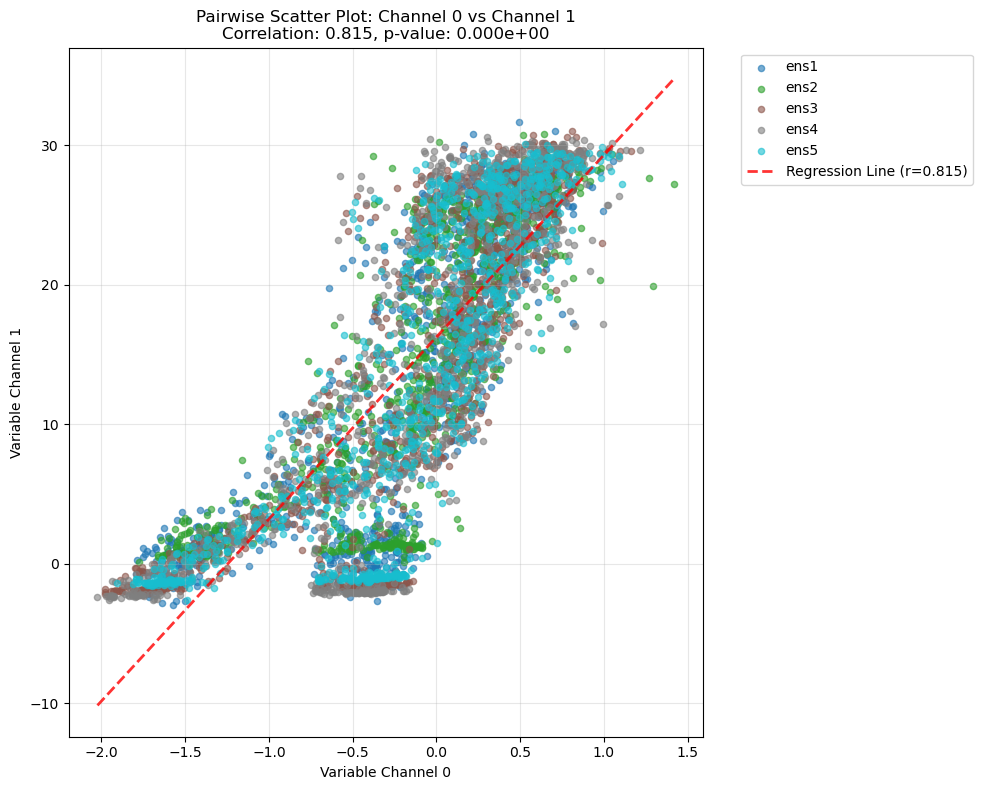

Correlation between Channel 0 and Channel 1: 0.815


In [139]:
# Example 1: Pairwise scatter plot between two specific variables
# Compare surface channel 0 and surface channel 1
fig, ax, corr = plot_pairwise_scatter(
    ensemble, 
    time_idx=time_idx, 
    var1_ch=0,  # First surface channel
    var2_ch=1,  # Second surface channel
    sample_size=1000
)
plt.show()

print(f"Correlation between Channel 0 and Channel 1: {corr:.3f}")


Analyzing correlations in Gulf Stream...
  - Gulf Stream: 16835 samples
  - Gulf Stream: 16835 samples


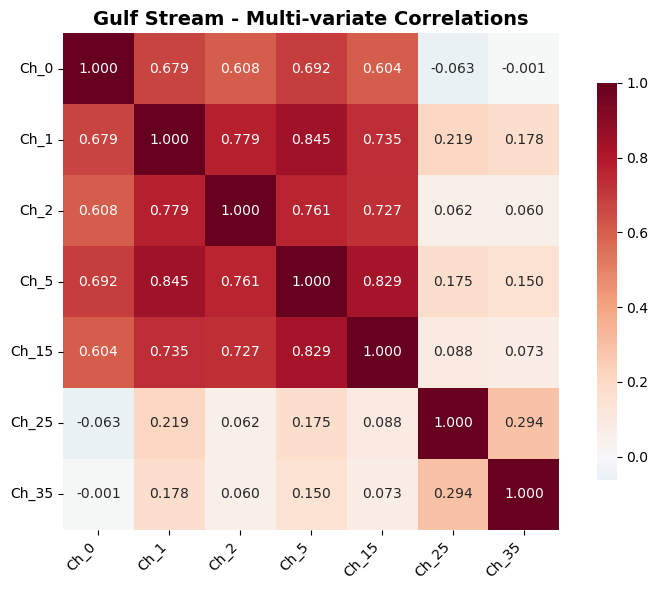


Analyzing correlations in Agulhas Current...
  - Agulhas Current: 20765 samples
  - Agulhas Current: 20765 samples


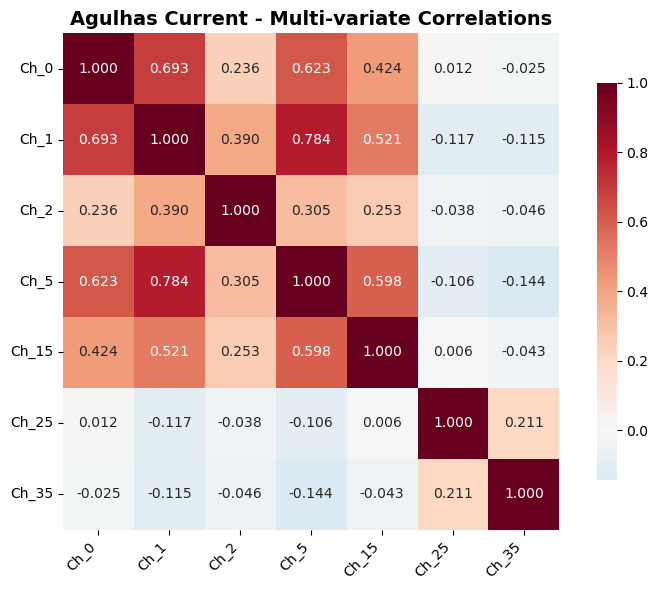


Analyzing correlations in Kuroshio Current...
  - Kuroshio Current: 19625 samples
  - Kuroshio Current: 19625 samples


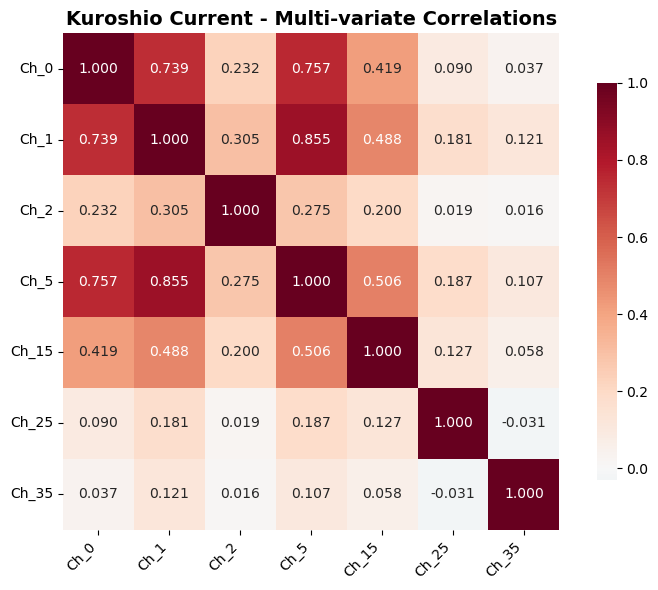


Analyzing correlations in Antarctic Circumpolar...
  - Antarctic Circumpolar: 573960 samples
  - Antarctic Circumpolar: 573960 samples


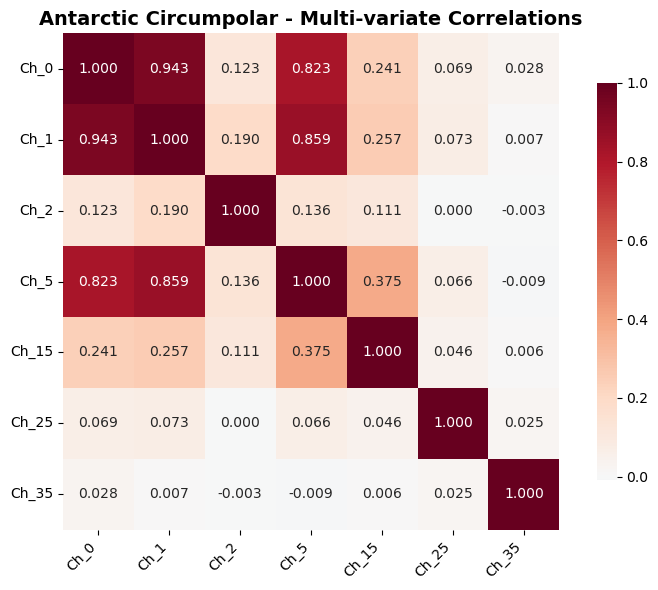


=== REGIONAL CORRELATION SUMMARY ===

Gulf Stream:
  - Sample size: 16835
  - Mean correlation: 0.404
  - Max correlation: 0.845
  - Min correlation: -0.063
  - Std correlation: 0.319

Agulhas Current:
  - Sample size: 20765
  - Mean correlation: 0.211
  - Max correlation: 0.784
  - Min correlation: -0.144
  - Std correlation: 0.296

Kuroshio Current:
  - Sample size: 19625
  - Mean correlation: 0.271
  - Max correlation: 0.855
  - Min correlation: -0.031
  - Std correlation: 0.255

Antarctic Circumpolar:
  - Sample size: 573960
  - Mean correlation: 0.208
  - Max correlation: 0.943
  - Min correlation: -0.009
  - Std correlation: 0.290


In [140]:
# Example 2: Regional correlation analysis
# Analyze correlations within each oceanic region
regional_correlations = analyze_regional_correlations(
    ensemble, 
    regions, 
    time_idx=time_idx, 
    channels_to_analyze=[0, 1, 2, 5, 15, 25, 35]  # Mix of surface and depth channels
)

# Print summary of regional correlations
print("\n=== REGIONAL CORRELATION SUMMARY ===")
for region_name, region_data in regional_correlations.items():
    if 'correlation_matrix' in region_data:
        corr_matrix = region_data['correlation_matrix']
        # Get upper triangle correlations (exclude diagonal)
        mask = np.triu(np.ones_like(corr_matrix.values, dtype=bool), k=1)
        upper_corrs = corr_matrix.values[mask]
        
        print(f"\n{region_name}:")
        print(f"  - Sample size: {region_data['n_samples']}")
        print(f"  - Mean correlation: {np.mean(upper_corrs):.3f}")
        print(f"  - Max correlation: {np.max(upper_corrs):.3f}")
        print(f"  - Min correlation: {np.min(upper_corrs):.3f}")
        print(f"  - Std correlation: {np.std(upper_corrs):.3f}")

=== DEPTH-WISE CORRELATION COMPARISON ===

Analyzing Depth_Level_0 correlations for channels: [5, 15, 25, 35]
Variable names: ['thetao_shallow_L0', 'so_shallow_L0', 'uo_shallow_L0', 'vo_shallow_L0']
Data shape after preprocessing: (3243975, 4)
Valid samples: 3243975 / 4838400
Data shape after preprocessing: (3243975, 4)
Valid samples: 3243975 / 4838400
Depth Level 0:
  Variables: ['thetao_shallow_L0', 'so_shallow_L0', 'uo_shallow_L0', 'vo_shallow_L0']
  Mean correlation: 0.088
  Max correlation: 0.582
  Min correlation: -0.059

Analyzing Depth_Level_5 correlations for channels: [10, 20, 30, 40]
Variable names: ['thetao_shallow_L5', 'so_shallow_L5', 'uo_shallow_L5', 'vo_shallow_L5']
Depth Level 0:
  Variables: ['thetao_shallow_L0', 'so_shallow_L0', 'uo_shallow_L0', 'vo_shallow_L0']
  Mean correlation: 0.088
  Max correlation: 0.582
  Min correlation: -0.059

Analyzing Depth_Level_5 correlations for channels: [10, 20, 30, 40]
Variable names: ['thetao_shallow_L5', 'so_shallow_L5', 'uo_sha

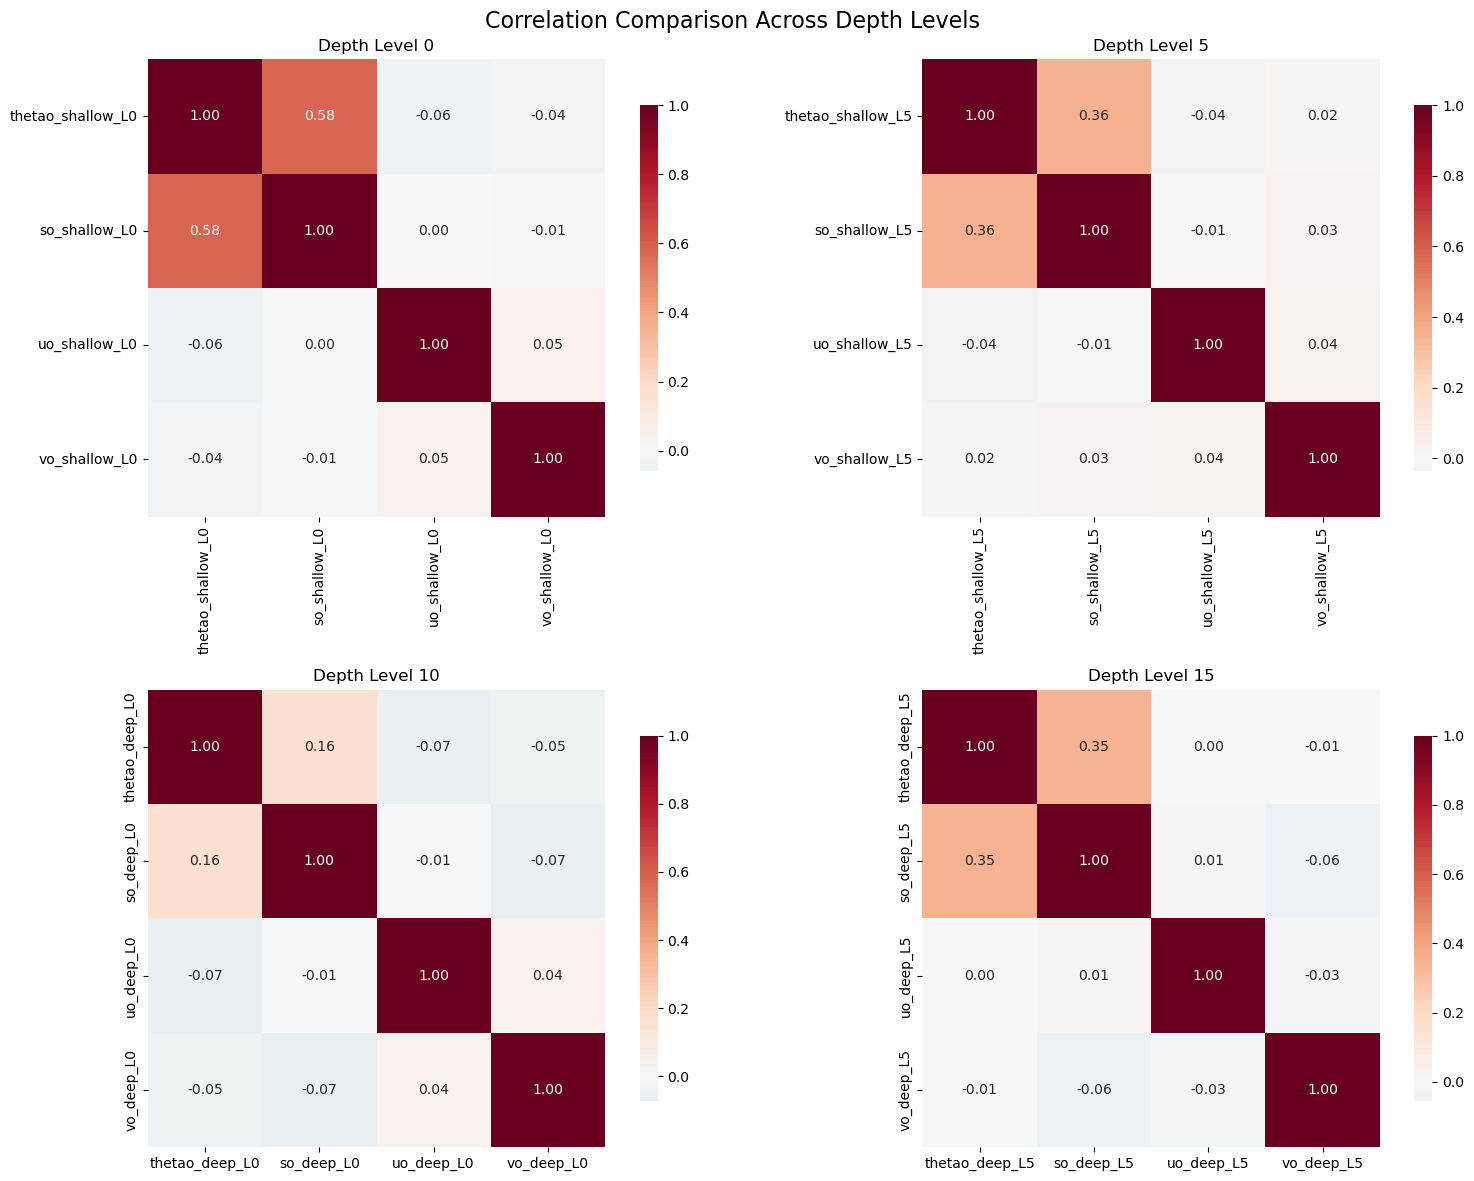

In [141]:
# Example 3: Compare correlations across different depth levels
def compare_depth_correlations(ensemble, time_idx=0, depth_levels=[0, 5, 10, 15]):
    """
    Compare how correlations between the same variables change with depth.
    """
    print("=== DEPTH-WISE CORRELATION COMPARISON ===\n")
    
    depth_comparison = {}
    
    for depth_level in depth_levels:
        try:
            # Calculate correlations for this depth level
            depth_corr, depth_vars, _ = calculate_multivariate_correlations(
                ensemble, time_idx=time_idx, depth_level=depth_level, 
                correlation_type='pearson'
            )
            
            # Store results
            depth_comparison[depth_level] = {
                'correlation_matrix': depth_corr,
                'variable_names': depth_vars
            }
            
            # Calculate summary statistics
            mask = np.triu(np.ones_like(depth_corr.values, dtype=bool), k=1)
            upper_corrs = depth_corr.values[mask]
            
            print(f"Depth Level {depth_level}:")
            print(f"  Variables: {depth_vars}")
            print(f"  Mean correlation: {np.mean(upper_corrs):.3f}")
            print(f"  Max correlation: {np.max(upper_corrs):.3f}")
            print(f"  Min correlation: {np.min(upper_corrs):.3f}")
            print()
            
        except Exception as e:
            print(f"Error at depth level {depth_level}: {e}")
    
    # Create comparison plot
    if len(depth_comparison) > 1:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        for i, (depth_level, data) in enumerate(depth_comparison.items()):
            if i < 4:  # Max 4 subplots
                sns.heatmap(data['correlation_matrix'], annot=True, cmap='RdBu_r', 
                           center=0, square=True, fmt='.2f', ax=axes[i],
                           cbar_kws={'shrink': 0.8})
                axes[i].set_title(f'Depth Level {depth_level}')
        
        # Hide unused subplots
        for i in range(len(depth_comparison), 4):
            axes[i].set_visible(False)
        
        plt.suptitle('Correlation Comparison Across Depth Levels', fontsize=16)
        plt.tight_layout()
        plt.show()
    
    return depth_comparison

# Run depth correlation comparison
depth_correlations = compare_depth_correlations(ensemble, time_idx=time_idx)